# Find optimal TTNDO structure for a Simple Open Quantum System

We simulate a TFI model
$$
H = \sum_{i=1}^{L-1} X_iX_{i+1} + \sum_{i=1}^L Z_i
$$
with local relaxation $\sigma^-_i$ and dephasing $Z_i$.

In [32]:
# Parameters for simulating a 1D transverse field Ising model with dissipation
import numpy as np

# length: Number of spins in the chain
length = 11
# ext_magn: External magnetic field strength in z-direction
ext_magn = 0.5
# coupling: Nearest-neighbor coupling strength for XX interactions
coupling = 1.0 
# relaxation_rate: Local amplitude damping (relaxation) rate
relaxation_rate = 0.1
# dephasing_rate: Local dephasing rate
dephasing_rate = 0.1
# time_step_size: Size of time steps for evolution
time_step_size = 0.01
# final_time: Total simulation time
final_time = 0.4
# Initial local states to cunstruct product state
phys_tensor = np.array([1, 0])

## Exact Solution with Qutip

In [10]:
from TFI_1D_Qutip import TFI_1D_Qutip

tfi_system = TFI_1D_Qutip(L=length, 
                        coupling=coupling, 
                        ext_magn=ext_magn, 
                        periodic=False, 
                        use_single_precision = False)
# Initial State
initial_state = tfi_system.uniform_product_state(phys_tensor)
# Build Jump Operators
jump_operators = tfi_system.build_jump_operators(relaxation_rate, dephasing_rate)
# Observables
energy_op = tfi_system.hamiltonian
total_mag_z = sum(tfi_system.sz_ops)
total_mag_z /= length
e_ops = [total_mag_z , energy_op]
# Evolve the System 
options = {'method': 'bdf', 
            'atol': 1e-8,
            'rtol': 1e-6,
            'nsteps': 1000 }         
result, solve_time = tfi_system.evolve_system_lindblad(initial_state=initial_state,
                                                        final_time=final_time,
                                                        time_step_size=time_step_size,
                                                        jump_operators=jump_operators,
                                                        e_ops=e_ops,
                                                        options=options)
# Collect the results
exact_magns = np.array(result.expect[:-1])
exact_energy = np.array(result.expect[-1])
print(f"results shape: {np.array(result.expect).shape}")

Evolution completed in 34.30 seconds
results shape: (2, 41)


## Tree Tensor Network Simulation

In [34]:
from fractions import Fraction

from numpy import ndarray
from typing import Union
from pytreenet.special_ttn.binary import generate_binary_ttns
from pytreenet.ttns.ttndo import (SymmetricTTNDO,
                                  IntertwinedTTNDO,
                                  from_ttns_symmetric,
                                  from_mps_intertwined,
                                  from_ttns_fully_intertwined,
                                  from_ttns_physically_intertwined)
from pytreenet.operators.models import (ising_model,
                                        flipped_ising_model,
                                        local_magnetisation,)
from pytreenet.operators.sim_operators import single_site_operators
from pytreenet.operators.common_operators import pauli_matrices
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.operators.lindbladian import generate_lindbladian
from pytreenet.ttno.ttno_class import TreeTensorNetworkOperator
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.operators.common_operators import (bosonic_operators,pauli_matrices)
from pytreenet.ttns.ttns import TreeTensorNetworkState
from pytreenet.time_evolution.bug import BUG, BUGConfig
from pytreenet.ttno.ttno_class import TTNO


In [35]:
def open_ising_model_ttno(length: int,
                          ttndo: Union[SymmetricTTNDO, IntertwinedTTNDO],
                          ext_magn: float,
                          coupling: float,
                          relaxation_rate: float,
                          dephasing_rate: float,
                          flipped: bool = False
                          ) -> tuple[TreeTensorNetworkOperator, Hamiltonian]:
    """
    Generates the Hamiltonian for the open Ising model.

    Additionally to the usual TFI model two jump operators act on every site
    separately. The first jump operator is relaxation and the second is 
    dephasing.

    Args:
        length (int): The length of the system.
        ttndo (SymmetricTTNDO): The TTNDO of the system.
        ext_magn (float): The external magnetic field.
        coupling (float): The coupling strength.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.
        flipped (bool): Whether to use the flipped Ising model.

    Returns:
        TreeTensorNetworkOperator: The TTNO.
    
    """
    node_identifiers = phys_node_identifiers(length)
    nn_pairs = [(node_identifiers[i], node_identifiers[i+1])
                for i in range(length-1)]
    if flipped:
        ham = flipped_ising_model(nn_pairs,
                                  ext_magn,
                                  factor=coupling)
    else:
        ham = ising_model(nn_pairs,
                          ext_magn,
                          factor=coupling)
    jump_ops, conversion_dict, coeff_dict = jump_operators(length,
                                                          relaxation_rate,
                                                          dephasing_rate)
    lindbladian = generate_lindbladian(ham,
                                        jump_ops,
                                        conversion_dict,
                                        coeff_dict)
    ttno = TreeTensorNetworkOperator.from_hamiltonian(lindbladian,
                                                      ttndo)
    return ttno, ham

def jump_operators(length: int,
                   relaxation_rate: float,
                   dephasing_rate:float
                   ) -> tuple[list[tuple[Fraction,str,TensorProduct]], dict[str,ndarray], dict[str,complex]]:
    """
    Generates the jump operators for the open Ising model.

    Args:
        length (int): The length of the system.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.

    Returns:
        list[tuple[Fraction,str,TensorProduct]]: The jump operator terms.
        dict[str,ndarray]: The jump operator conversion dictionary.
        dict[str,float]: The jump operator coefficient mapping
    
    """
    node_identifiers = phys_node_identifiers(length)
    # Create relaxation jump operators
    rel_fac_name = "relaxation_rate"
    factor = (Fraction(1), rel_fac_name)
    relax_name = "sigma_-"
    relaxation_ops = single_site_operators(relax_name,
                                           node_identifiers,
                                           factor)
    # Create dephasing jump operators
    deph_fac_name = "dephasing_rate"
    factor = (Fraction(1), deph_fac_name)
    deph_name = "Z"
    dephasing_ops = single_site_operators(deph_name,
                                          node_identifiers,
                                          factor)
    # Combine the jump operators
    jump_ops = list(relaxation_ops.values())
    jump_ops.extend(list(dephasing_ops.values()))
    # Create the jump operator matrix mapping
    conversion_dict = {relax_name: bosonic_operators()[1],
                       deph_name: pauli_matrices()[2]}
    # Create the jump operator coefficient mapping
    coeff_dict = {rel_fac_name: complex(relaxation_rate),
                  deph_fac_name: complex(dephasing_rate)}
    return jump_ops, conversion_dict, coeff_dict

def phys_node_identifiers(length: int) -> list[str]:
    """
    Generates the node identifiers for the physical nodes.

    Args:
        length (int): The length of the system.
    
    Returns:
        list[str]: The node identifiers.
    """
    return [f"qubit{i}" for i in range(length)]

def open_ising_operators(length: int,
                         ttns: TreeTensorNetworkState,
                         ising_ham: Hamiltonian
                         ) -> dict:
    """
    Generates the operators to be evaluated for the open Ising model.
    
    Args:
        length (int): The length of the system.
        ttns (TreeTensorNetworkState): The TTN state of the system.
        ising_ham (Hamiltonian): The Ising Hamiltonian.
    
    Returns:
        dict: The operators.

    """
    node_identifiers = phys_node_identifiers(length)
    ops = {key: tup[2]
           for key, tup in local_magnetisation(node_identifiers).items()}
    ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham,
                                                      ttns)
    ops["energy"] = ttno

    Identity = TTNO.Identity(ttns)
    ops["Identity"] = Identity
    return ops

In [36]:
import time 
from ttn_vis import (visualize_binary_ttns,
                    visualize_symmetric_ttndo,
                    visualize_intertwined_ttndo)


def run_simulation(ttndo_type_name,
                   initial_bond_dim,
                   max_effective_ham_dim,
                   total_tol,
                   depth,
                   visualize = False):
    
    print(f"{ttndo_type_name} with depth = {depth}")
    
    # Generate binary tree tensor network state
    ttns = generate_binary_ttns(num_phys=length,
                                bond_dim=initial_bond_dim,
                                phys_tensor=phys_tensor,
                                depth=depth)
    if visualize :
        ttns_virtual_count = sum(1 for node_id in ttns.nodes if not ("qubit" in node_id or "site" in node_id))
        visualize_binary_ttns(ttns, 
                              title=f'Binary TTNS Hierarchical (Depth={depth}, #qubits={length}, #Virtual nodes={ttns_virtual_count})',
                              layout_type="hierarchical",
        simplified_labels=True)
        visualize_binary_ttns(ttns, 
                            title=f'Binary TTNS Radial (Depth={depth}, #qubits={length}, #Virtual nodes={ttns_virtual_count})',
                            layout_type="radial",
                            simplified_labels=True)
    if ttndo_type_name == "symmetric" :
        ttndo = from_ttns_symmetric(ttns, initial_bond_dim)
        if visualize :
            # Count ket virtual nodes and double it
            sym_virtual_count = ttns_virtual_count * 2 + 1
            visualize_symmetric_ttndo(ttndo, 
                                      title=f'Symmetric TTNDO (Depth={depth}, #qubits={length}, #Virtual nodes={sym_virtual_count})',
                                      simplified_labels=True)
    elif ttndo_type_name == "fully_intertwined" :
        if depth == 0:
            raise ValueError("from_ttns_fully_intertwined does not accept depth=0")
        ttndo = from_ttns_fully_intertwined(ttns, initial_bond_dim, phys_tensor) 
        if visualize :
           # Count ket virtual nodes and double it
            int_ket_virtual_count = sum(1 for node_id in ttndo.nodes 
                                        if "_ket" in node_id and not ("qubit" in node_id or "site" in node_id))
            int_virtual_count = int_ket_virtual_count * 2            
            visualize_intertwined_ttndo(ttndo, 
                                        title=f'Full Intertwined TTNDO Hierarchical (Depth={depth}, #qubits={length}, #Virtual nodes={int_virtual_count})',
                                        layout_type="hierarchical",
                                        simplified_labels=True)
            visualize_intertwined_ttndo(ttndo, 
                                        title=f'Full Intertwined TTNDO Radial (Depth={depth}, #qubits={length}, #Virtual nodes={int_virtual_count})',
                                        layout_type="radial",
                                        simplified_labels=True)
    elif ttndo_type_name == "physically_intertwined" :
        if depth == 0:
            raise ValueError("from_ttns_fully_intertwined does not accept depth=0")
        ttndo = from_ttns_physically_intertwined(ttns, initial_bond_dim, phys_tensor) 
        if visualize :
            visualize_intertwined_ttndo(ttndo, 
                                        title=f'Physical Intertwined TTNDO Hierarchical (Depth={depth}, #qubits={length}, #Virtual nodes={int_virtual_count})',
                                        layout_type="hierarchical",
                                        simplified_labels=True)

            # Intertwined TTNDO - Radial
            visualize_intertwined_ttndo(ttndo, 
                                        title=f'Physical Intertwined TTNDO Radial (Depth={depth}, #qubits={length}, #Virtual nodes={int_virtual_count})',
                                        layout_type="radial",
                                        simplified_labels=True)
    elif ttndo_type_name == "mps_intertwined":
        if depth != 0:
            raise ValueError("MPS intertwined TTNDO only accepts depth=0")
        ttndo = from_mps_intertwined(ttns, initial_bond_dim, phys_tensor)  
        if visualize :       
            visualize_intertwined_ttndo(ttndo, 
                                        title=f'MPS Intertwined TTNDO Hierarchical (Depth={depth}, #qubits={length})',
                                        layout_type="hierarchical",
                                        simplified_labels=True)

            visualize_intertwined_ttndo(ttndo, 
                                        title=f'MPS Intertwined TTNDO Radial (Depth={depth}, #qubits={length})',
                                        layout_type="radial",
                                        simplified_labels=True)
    # Define Ising model
    lindbladian_ttno, ising_ham = open_ising_model_ttno(length,
                                                        ttndo,
                                                        ext_magn,
                                                        coupling,
                                                        relaxation_rate,
                                                        dephasing_rate)
    
    # Observables
    operators = open_ising_operators(length,
                                     ttns,
                                     ising_ham)

    # BUG simulation
    config = BUGConfig(max_bond_dim= np.inf,
                       max_effective_ham_dim=max_effective_ham_dim,
                       total_tol=total_tol,
                       sum_trunc=True,
                       sum_renorm = False,
                       record_bond_dim=False)

    bug = BUG(ttndo,lindbladian_ttno,time_step_size,final_time,operators,config=config)
    start_time = time.time()
    bug.run()
    CPU_time = time.time() - start_time

    # Collect the results
    bug_magns = np.sum(bug._results[:-3], axis=0) / length
    bug_energy = bug._results[-3]
    trace = bug._results[-2]

    print(f"CPU_time = {CPU_time:.2f} s")
        
    return bug_magns, bug_energy , trace , bug.bond_dims

def Calculate_absolute_error_and_save(results, 
                                      bug_magns, 
                                      bug_energy, 
                                      trace,
                                      ttndo_type_name, 
                                      depth, 
                                      exact_magns, 
                                      exact_energy):
    if ttndo_type_name not in results:
        results[ttndo_type_name] = {}
    
    magn_error = np.abs(bug_magns - exact_magns)
    magn_error = magn_error.reshape(-1)
    energy_error = np.abs(bug_energy - exact_energy)
    energy_error = energy_error.reshape(-1)
    
    results[ttndo_type_name][depth] = {"magn_error": magn_error,
                                       "energy_error": energy_error,
                                       "trace": trace}


# Find Optimal TTNDO represenation

we examine four distinct TTNDO structural at various tree depths to identify optimal configurations for simulating open quantum systems.

### TTNDO Structures
1. **Symmetric TTNDO**
2. **Fully Intertwined TTNDO**
3. **Physically Intertwined TTNDO**
4. **Intertwined MPS TTNO**

For each TTNDO type $\theta \in \{\text{symmetric, fully\_intertwined, physically\_intertwined, mps\_Intertwined}\}$ and depth $d \in \{\text{depths}\}$, we try different initial_bond_dim and max_bond_dim
to have a simulation with CPU_time = 

1. $$\{\langle\hat{\sigma}_x\rangle(t), E(t)\} = \text{run\_simulation}(d, \theta, \mathcal{D}_{\text{init}}, \text{max\_effective\_ham\_dim})$$
   
2. Calculate error :
$$\epsilon_{\text{magn}} = |\langle\hat{\sigma}_z\rangle - \langle\hat{\sigma}_z\rangle_{\text{exact}}|$$
$$\epsilon_{\text{energy}} = |\hat{E} - \hat{E}_{\text{exact}}|$$
$$ {Trace\_preservation} = | {Trace(TTNDO)} - 1 | $$


In [17]:
results = {}

## Symmetric TTNDO

In [18]:
depth = 4

initial_bond_dim = 4
max_effective_ham_dim = 2500 
total_tol = 1e-5

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "symmetric", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "symmetric", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

symmetric with depth = 4


100%|██████████| 41/41 [04:29<00:00,  6.58s/it]

CPU_time = 269.96 s


In [28]:
depth = 3

initial_bond_dim = 4
max_effective_ham_dim = 1600 
total_tol = 1e-4

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "symmetric", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "symmetric", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

symmetric with depth = 3


100%|██████████| 41/41 [05:25<00:00,  7.94s/it]

CPU_time = 325.68 s


In [26]:
depth = 2

initial_bond_dim = 4
max_effective_ham_dim = 2200 
total_tol = 1e-6

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "symmetric", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "symmetric", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

symmetric with depth = 2


100%|██████████| 41/41 [04:09<00:00,  6.07s/it]

CPU_time = 249.06 s


In [21]:
depth = 1

initial_bond_dim = 4
max_effective_ham_dim = 2200
total_tol = 1e-5

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "symmetric", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "symmetric", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

symmetric with depth = 1


100%|██████████| 41/41 [03:45<00:00,  5.49s/it]

CPU_time = 225.27 s


In [57]:
depth = 0

initial_bond_dim = 4
max_effective_ham_dim = 1600 # 14 x 14 x 13 = 2548
total_tol = 1e-4

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "symmetric", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "symmetric", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

symmetric with depth = 0


100%|██████████| 41/41 [02:50<00:00,  4.15s/it]

CPU_time = 170.23 s


## Fully Intertwined TTNDO

In [31]:
depth = 4

initial_bond_dim = 10
max_effective_ham_dim = 2000
total_tol = 1e-8

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "fully_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "fully_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

fully_intertwined with depth = 4


100%|██████████| 41/41 [03:31<00:00,  5.15s/it]

CPU_time = 211.15 s


In [32]:
depth = 3

initial_bond_dim = 12
max_effective_ham_dim = 2400
total_tol = 1e-9

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "fully_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "fully_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

fully_intertwined with depth = 3


100%|██████████| 41/41 [03:20<00:00,  4.90s/it]

CPU_time = 200.91 s


In [37]:
depth = 2

initial_bond_dim = 6
max_effective_ham_dim = 3500
total_tol = 1e-12

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "fully_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "fully_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

fully_intertwined with depth = 2


100%|██████████| 41/41 [02:41<00:00,  3.94s/it]

CPU_time = 161.47 s


In [31]:
depth = 1

initial_bond_dim = 8
max_effective_ham_dim = 3500
total_tol = 1e-12

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "fully_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "fully_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

NameError: name 'run_simulation' is not defined

## Physically Intertwined TTNDO

In [43]:
depth = 4

initial_bond_dim = 10
max_effective_ham_dim = 2200
total_tol = 1e-8

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "physically_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "physically_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

physically_intertwined with depth = 4


100%|██████████| 41/41 [04:04<00:00,  5.97s/it]

CPU_time = 244.85 s


In [44]:
depth = 3

initial_bond_dim = 10
max_effective_ham_dim = 2600
total_tol = 1e-8

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "physically_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "physically_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

physically_intertwined with depth = 3


100%|██████████| 41/41 [03:59<00:00,  5.85s/it]

CPU_time = 239.99 s


In [45]:
depth = 2

initial_bond_dim = 6
max_effective_ham_dim = 3500
total_tol = 1e-12

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "physically_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "physically_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

physically_intertwined with depth = 2


100%|██████████| 41/41 [02:12<00:00,  3.23s/it]

CPU_time = 132.44 s


In [46]:
depth = 1

initial_bond_dim = 8
max_effective_ham_dim = 3500
total_tol = 1e-12

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "physically_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "physically_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

physically_intertwined with depth = 1


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]

CPU_time = 184.58 s


## Mps Intertwined TTNDO

In [55]:
depth = 0

initial_bond_dim = 8
max_effective_ham_dim = 1000 
total_tol = 1e-12

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "mps_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)
Calculate_absolute_error_and_save(results = results, bug_magns = bug_magns, bug_energy= bug_energy, trace = trace, ttndo_type_name = "mps_intertwined", depth = depth, exact_magns = exact_magns, exact_energy = exact_energy)

mps_intertwined with depth = 0


100%|██████████| 41/41 [04:05<00:00,  5.99s/it]

CPU_time = 245.44 s


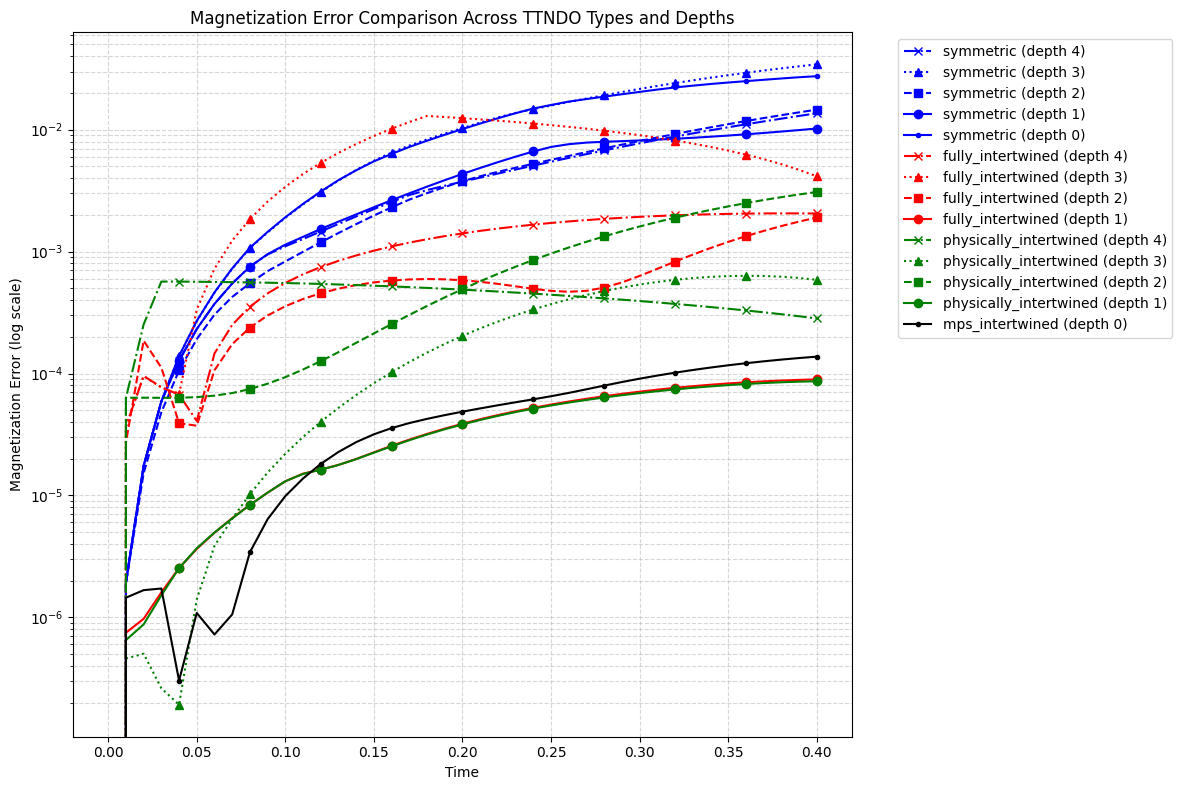

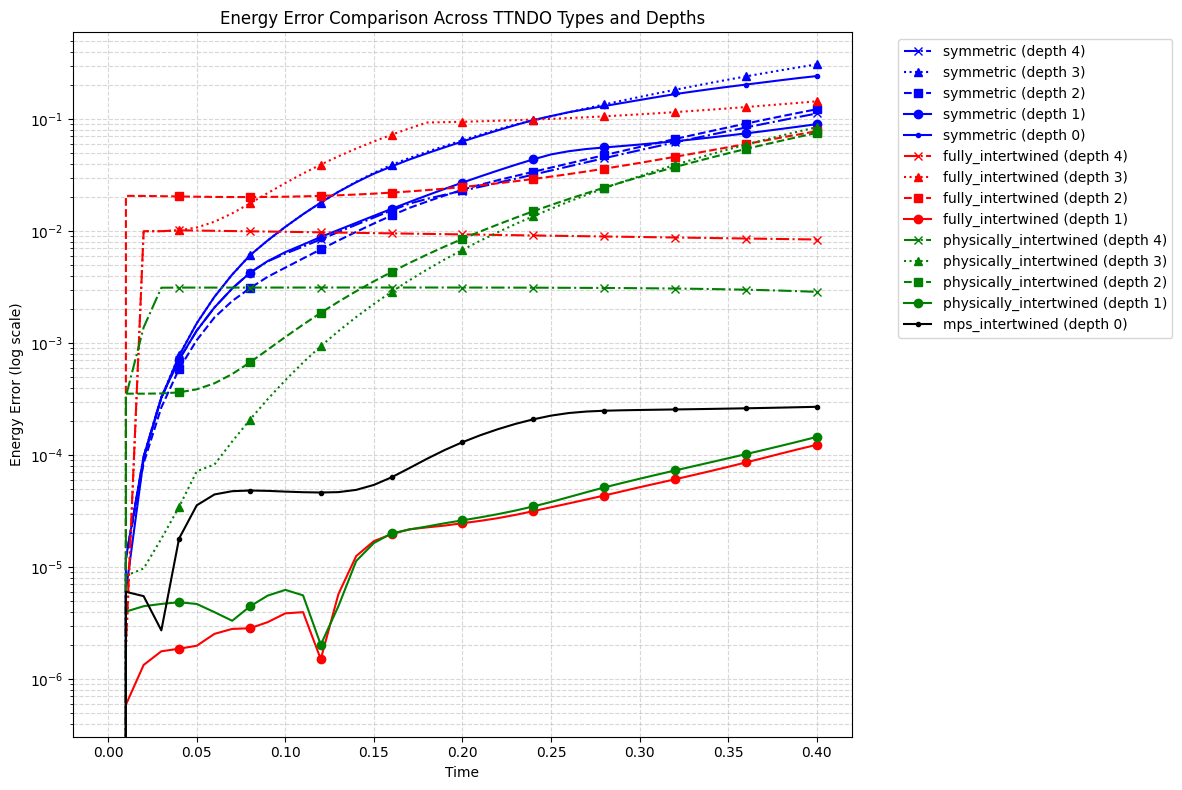

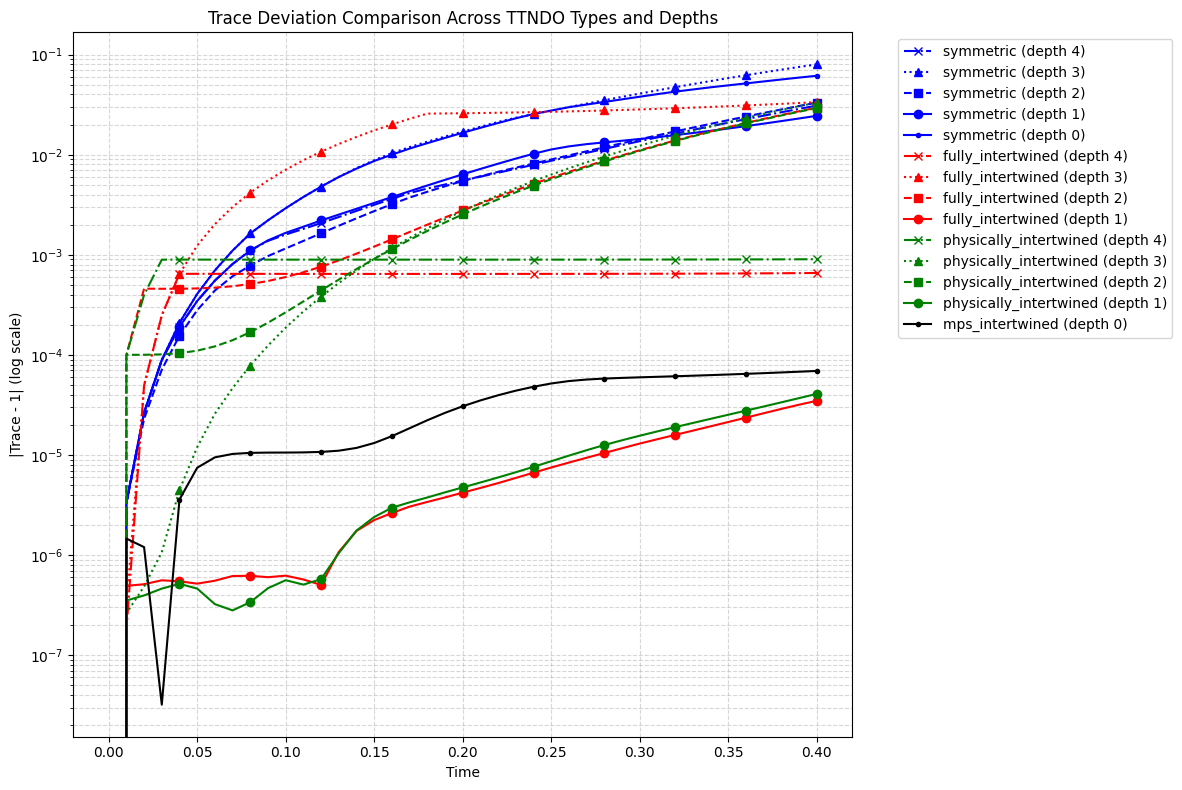

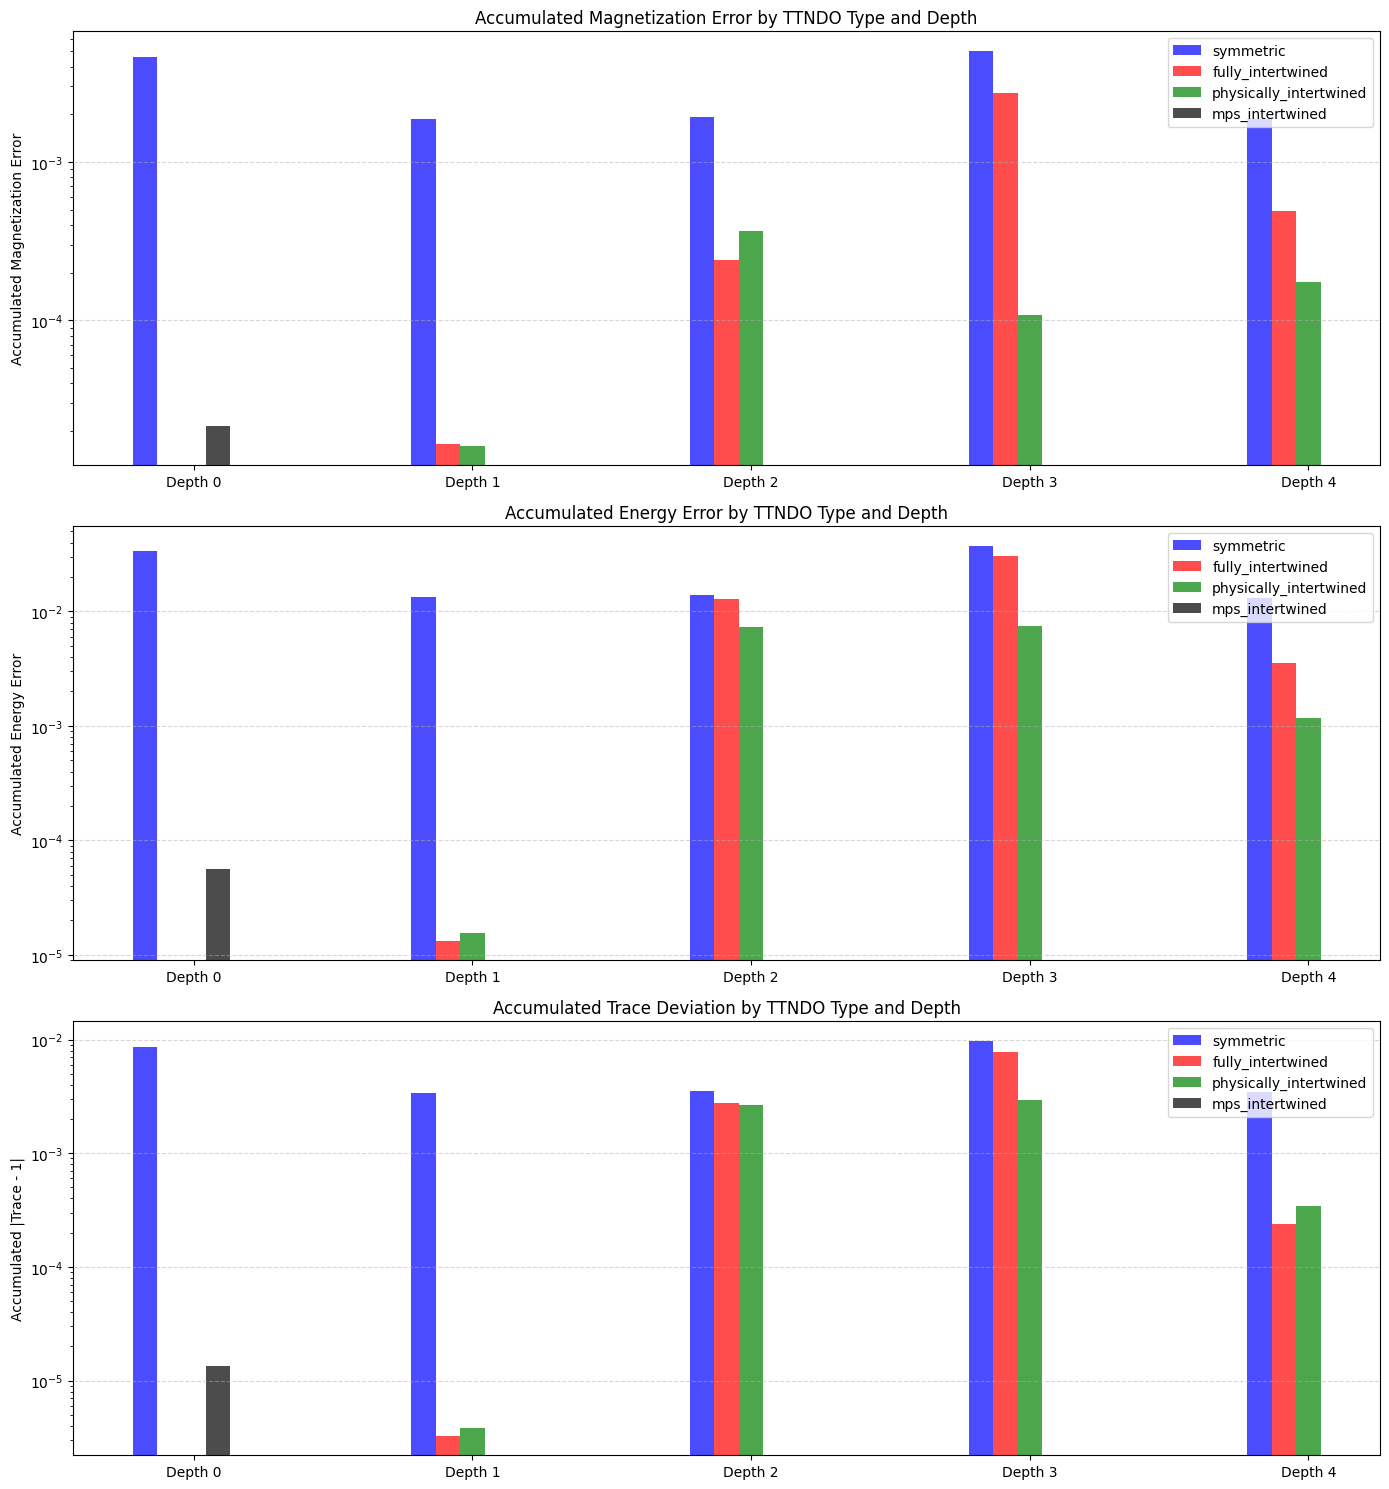

In [73]:
def plot_ttndo_errors(results, times):
    """
    Plot error metrics for all TTNDO types and depths, including time-series and accumulated errors.
    
    Parameters:
    -----------
    results : dict
        Nested dictionary with structure results[ttndo_type][depth] = {"magn_error": error_array, 
                                                                      "energy_error": error_array,
                                                                      "trace": trace_array}
    times : array-like
        Time points corresponding to the error data points
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define line styles and markers for different depths
    depth_styles = {
        1: {'linestyle': '-', 'marker': 'o'},
        2: {'linestyle': '--', 'marker': 's'},
        3: {'linestyle': ':', 'marker': '^'},
        4: {'linestyle': '-.', 'marker': 'x'},
        5: {'linestyle': (0, (3, 1, 1, 1)), 'marker': 'd'},  # Dash-dot-dot
        6: {'linestyle': (0, (3, 5, 1, 5)), 'marker': '*'},  # Sparse dash-dot
    }
    
    # Define colors for different TTNDO types
    ttndo_colors = {
        'symmetric': 'blue',
        'fully_intertwined': 'red',
        'physically_intertwined': 'green',
    }
    
    # Create figure for magnetization error
    plt.figure(figsize=(12, 8))
    
    # Loop through each TTNDO type and depth
    for ttndo_type, depths in results.items():
        for depth, error_data in depths.items():
            # Get the correct style for this depth
            style = depth_styles.get(depth, {'linestyle': '-', 'marker': '.'})
            color = ttndo_colors.get(ttndo_type, 'black')
            
            # Plot magnetization error
            plt.semilogy(times, error_data['magn_error'], 
                       label=f"{ttndo_type} (depth {depth})",
                       color=color,
                       linestyle=style['linestyle'],
                       marker=style['marker'],
                       markersize=6,
                       markevery=max(1, len(times)//10))  # Show markers at ~10 points
    
    plt.xlabel('Time')
    plt.ylabel('Magnetization Error (log scale)')
    plt.title('Magnetization Error Comparison Across TTNDO Types and Depths')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Create figure for energy error
    plt.figure(figsize=(12, 8))
    
    # Loop through each TTNDO type and depth for energy error
    for ttndo_type, depths in results.items():
        for depth, error_data in depths.items():
            # Get the correct style for this depth
            style = depth_styles.get(depth, {'linestyle': '-', 'marker': '.'})
            color = ttndo_colors.get(ttndo_type, 'black')
            
            # Plot energy error
            plt.semilogy(times, error_data['energy_error'], 
                       label=f"{ttndo_type} (depth {depth})",
                       color=color,
                       linestyle=style['linestyle'],
                       marker=style['marker'],
                       markersize=6,
                       markevery=max(1, len(times)//10))
    
    plt.xlabel('Time')
    plt.ylabel('Energy Error (log scale)')
    plt.title('Energy Error Comparison Across TTNDO Types and Depths')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Create figure for trace deviation (trace - 1)
    plt.figure(figsize=(12, 8))
    
    # Loop through each TTNDO type and depth for trace deviation
    for ttndo_type, depths in results.items():
        for depth, error_data in depths.items():
            # Get the correct style for this depth
            style = depth_styles.get(depth, {'linestyle': '-', 'marker': '.'})
            color = ttndo_colors.get(ttndo_type, 'black')
            
            # Calculate trace deviation (trace - 1)
            trace_deviation = np.abs(error_data['trace'] - 1.0)
            
            # Plot trace deviation
            plt.semilogy(times, trace_deviation, 
                       label=f"{ttndo_type} (depth {depth})",
                       color=color,
                       linestyle=style['linestyle'],
                       marker=style['marker'],
                       markersize=6,
                       markevery=max(1, len(times)//10))
    
    plt.xlabel('Time')
    plt.ylabel('|Trace - 1| (log scale)')
    plt.title('Trace Deviation Comparison Across TTNDO Types and Depths')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Create a summary bar plot for accumulated errors
    plt.figure(figsize=(14, 15))
    
    # Extract final error values for each configuration
    ttndo_types = list(results.keys())
    all_depths = sorted(set(depth for depths in results.values() for depth in depths.keys()))
    
    # Set up bar positions
    bar_width = 0.35
    index = np.arange(len(all_depths))
    
    for i, ttndo_type in enumerate(ttndo_types):
        accumulated_magn_errors = []
        accumulated_energy_errors = []
        accumulated_trace_deviations = []
        
        for depth in all_depths:
            if depth in results[ttndo_type]:
                acc_magn_error = np.trapezoid(results[ttndo_type][depth]["magn_error"], times)
                acc_energy_error = np.trapezoid(results[ttndo_type][depth]["energy_error"], times)
                acc_trace_deviation = np.trapezoid(np.abs(results[ttndo_type][depth]["trace"] - 1.0), times)
                
                accumulated_magn_errors.append(acc_magn_error)
                accumulated_energy_errors.append(acc_energy_error)
                accumulated_trace_deviations.append(acc_trace_deviation)
            else:
                accumulated_magn_errors.append(np.nan)
                accumulated_energy_errors.append(np.nan)
                accumulated_trace_deviations.append(np.nan)
        
        plt.subplot(3, 1, 1)
        plt.bar(index + i*bar_width/len(ttndo_types), accumulated_magn_errors, 
                bar_width/len(ttndo_types), label=ttndo_type, 
                color=ttndo_colors.get(ttndo_type, 'black'), alpha=0.7)
        
        plt.subplot(3, 1, 2)
        plt.bar(index + i*bar_width/len(ttndo_types), accumulated_energy_errors, 
                bar_width/len(ttndo_types), label=ttndo_type, 
                color=ttndo_colors.get(ttndo_type, 'black'), alpha=0.7)
        
        plt.subplot(3, 1, 3)
        plt.bar(index + i*bar_width/len(ttndo_types), accumulated_trace_deviations, 
                bar_width/len(ttndo_types), label=ttndo_type, 
                color=ttndo_colors.get(ttndo_type, 'black'), alpha=0.7)
    
    # Customize the plots
    plt.subplot(3, 1, 1)
    plt.title('Accumulated Magnetization Error by TTNDO Type and Depth')
    plt.ylabel('Accumulated Magnetization Error')
    plt.xticks(index + bar_width/2, [f'Depth {d}' for d in all_depths])
    plt.yscale('log')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.subplot(3, 1, 2)
    plt.title('Accumulated Energy Error by TTNDO Type and Depth')
    plt.ylabel('Accumulated Energy Error')
    plt.xticks(index + bar_width/2, [f'Depth {d}' for d in all_depths])
    plt.yscale('log')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.subplot(3, 1, 3)
    plt.title('Accumulated Trace Deviation by TTNDO Type and Depth')
    plt.ylabel('Accumulated |Trace - 1|')
    plt.xticks(index + bar_width/2, [f'Depth {d}' for d in all_depths])
    plt.yscale('log')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()

# Example usage:
times = np.arange(0, final_time + time_step_size, time_step_size)
plot_ttndo_errors(results, times)

## Visualize TTNDO structures

Visualizing networks: depth=4, sites=11
TTNS: 21 total nodes, 10 virtual nodes
Symmetric TTNDO: 43 total nodes, 21 virtual nodes
Intertwined TTNDO: 42 total nodes, 20 virtual nodes
Creating Binary TTNS Hierarchical plot...


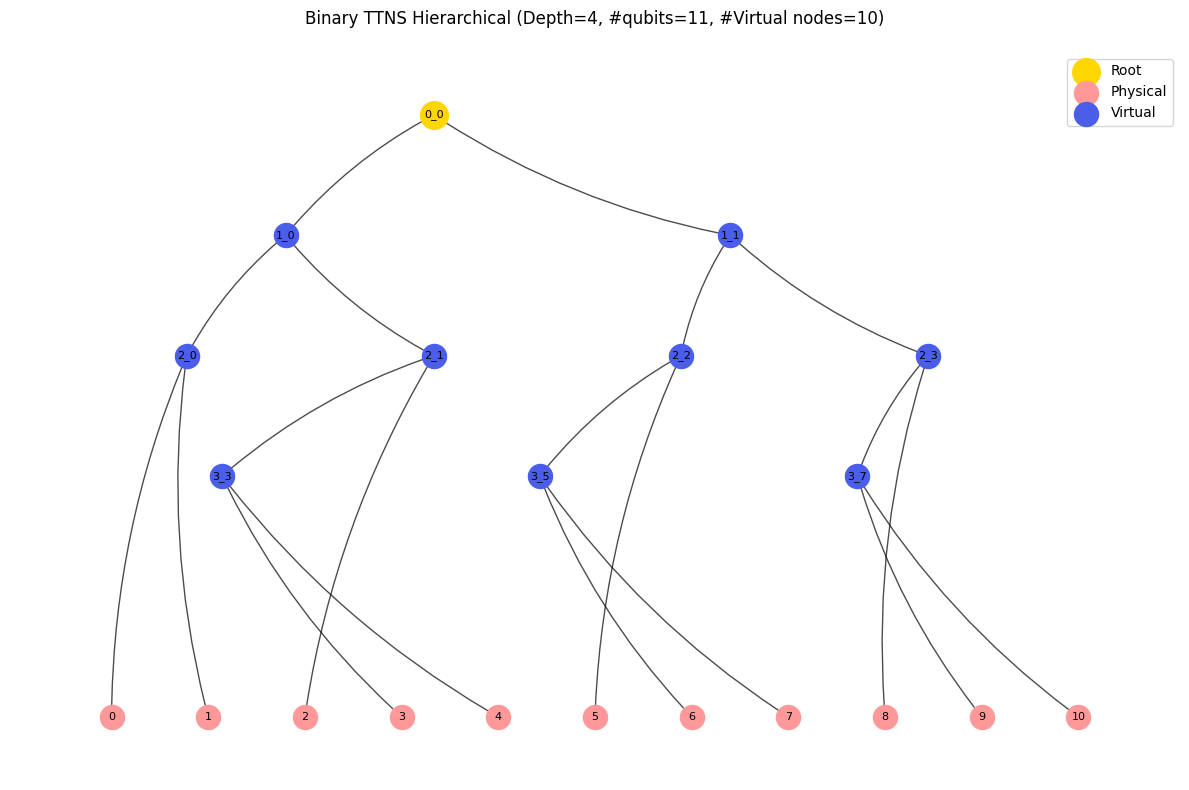

Creating Symmetric TTNDO plot...


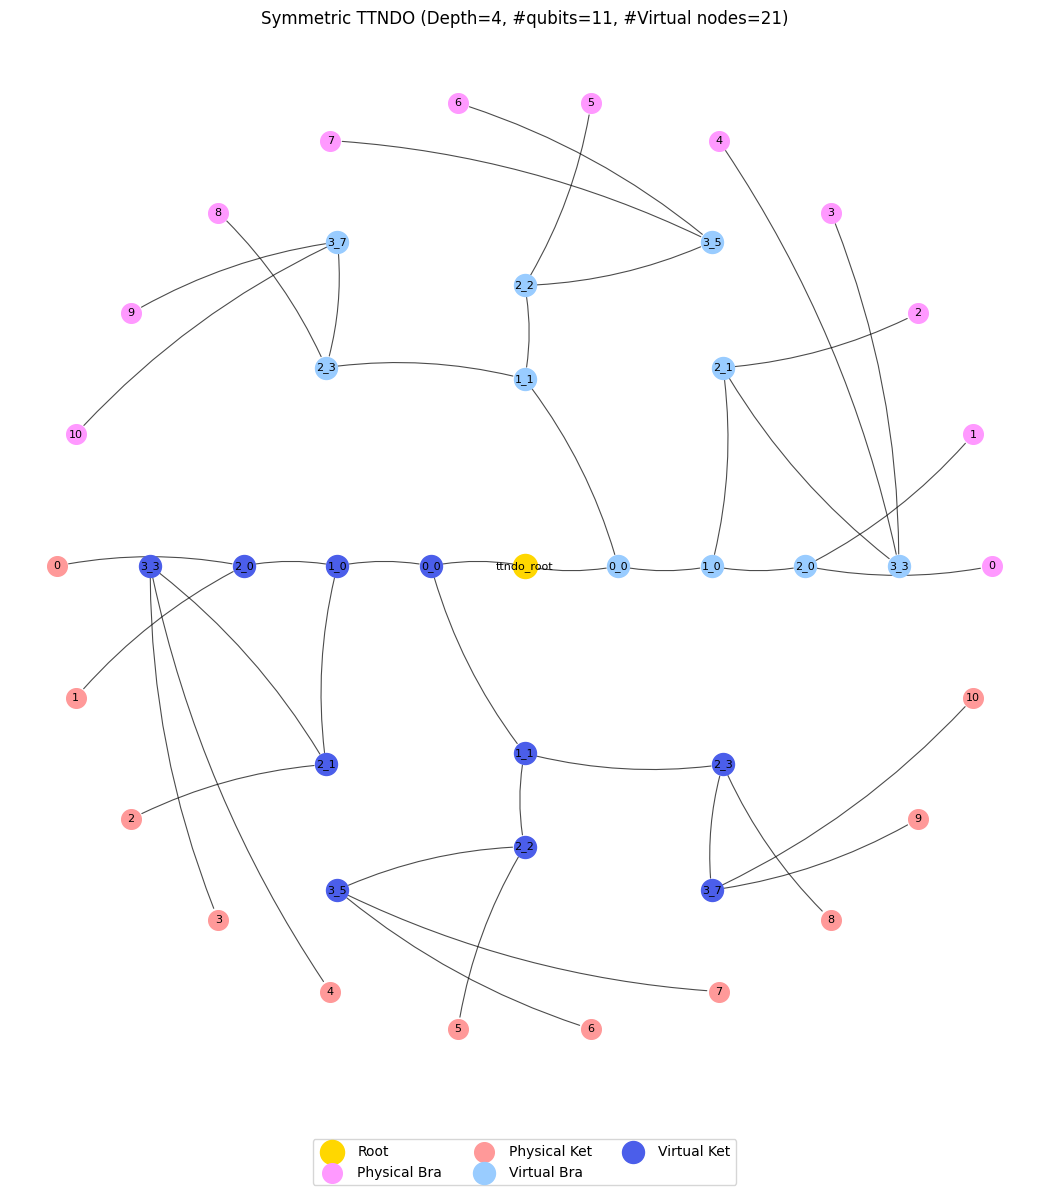

Creating Intertwined TTNDO Hierarchical plot...


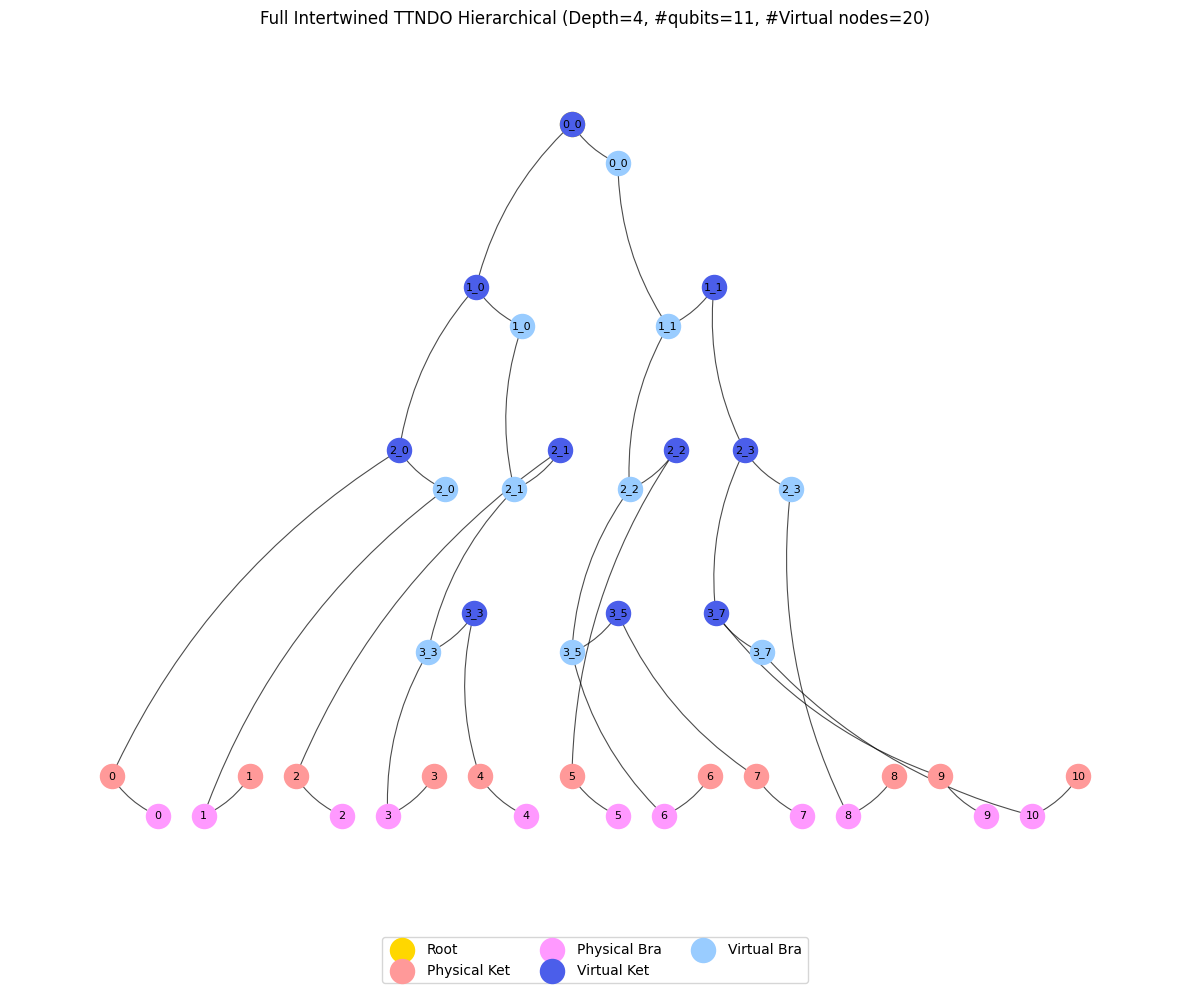

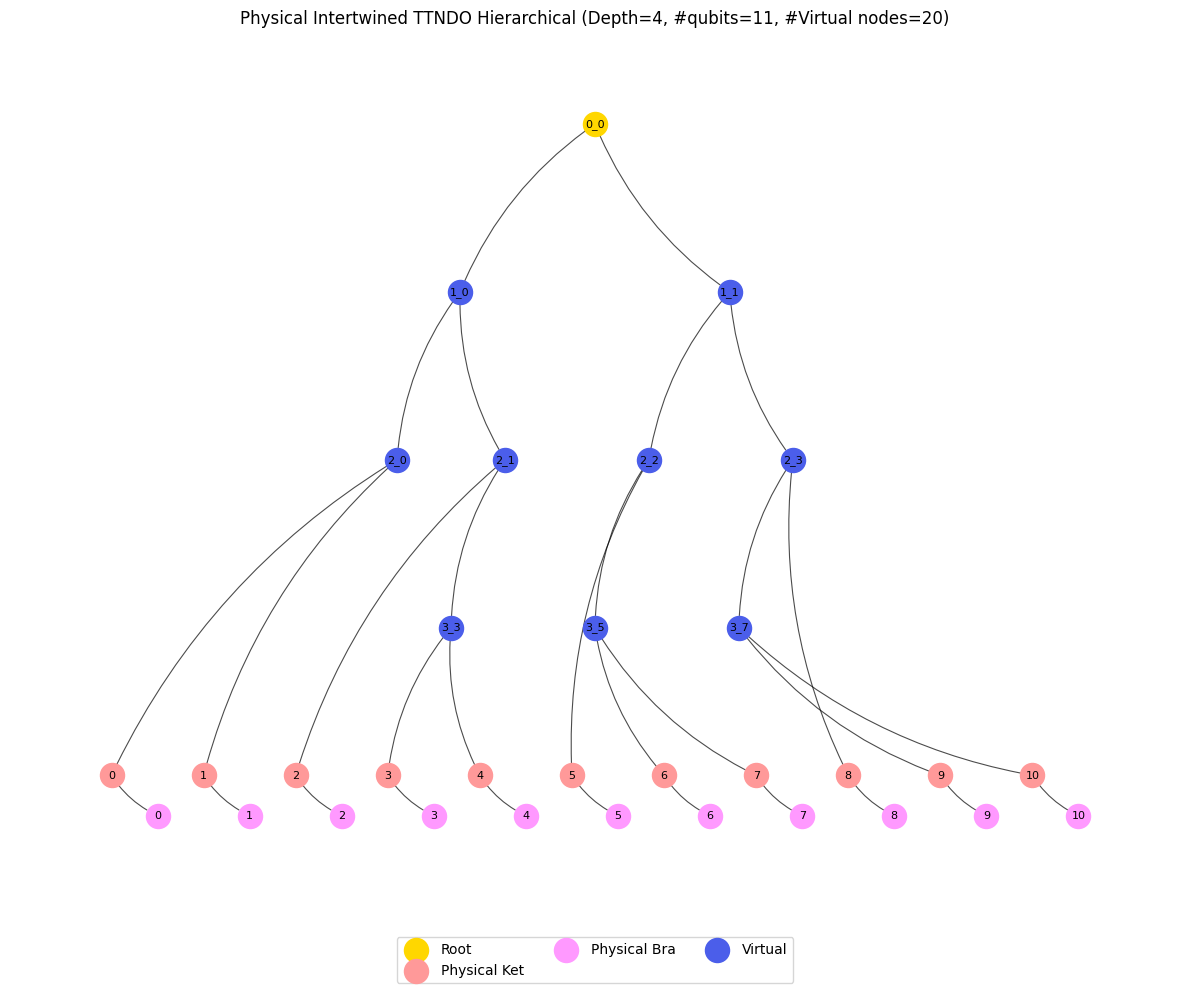

Visualizing networks: depth=3, sites=11
TTNS: 20 total nodes, 9 virtual nodes
Symmetric TTNDO: 41 total nodes, 19 virtual nodes
Intertwined TTNDO: 40 total nodes, 18 virtual nodes
Creating Binary TTNS Hierarchical plot...


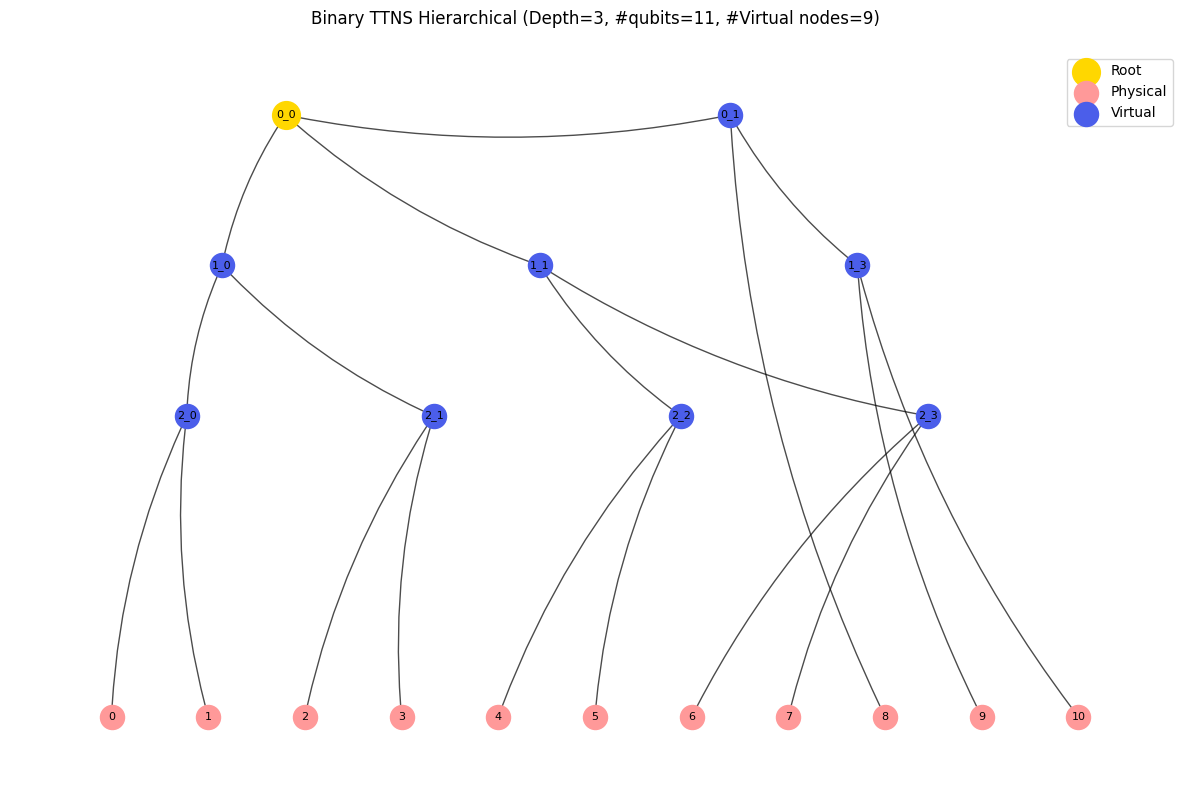

Creating Symmetric TTNDO plot...


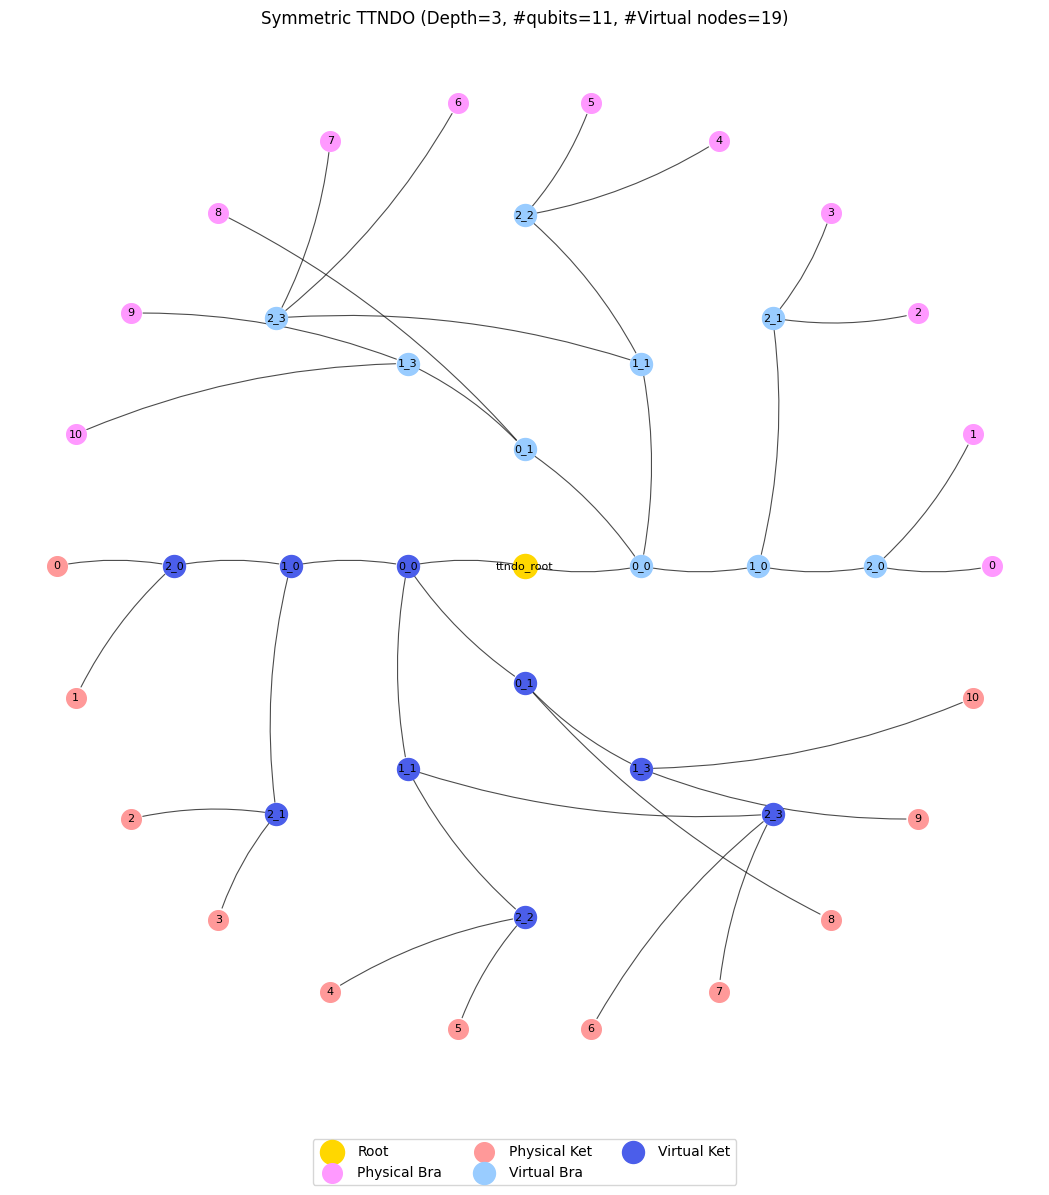

Creating Intertwined TTNDO Hierarchical plot...


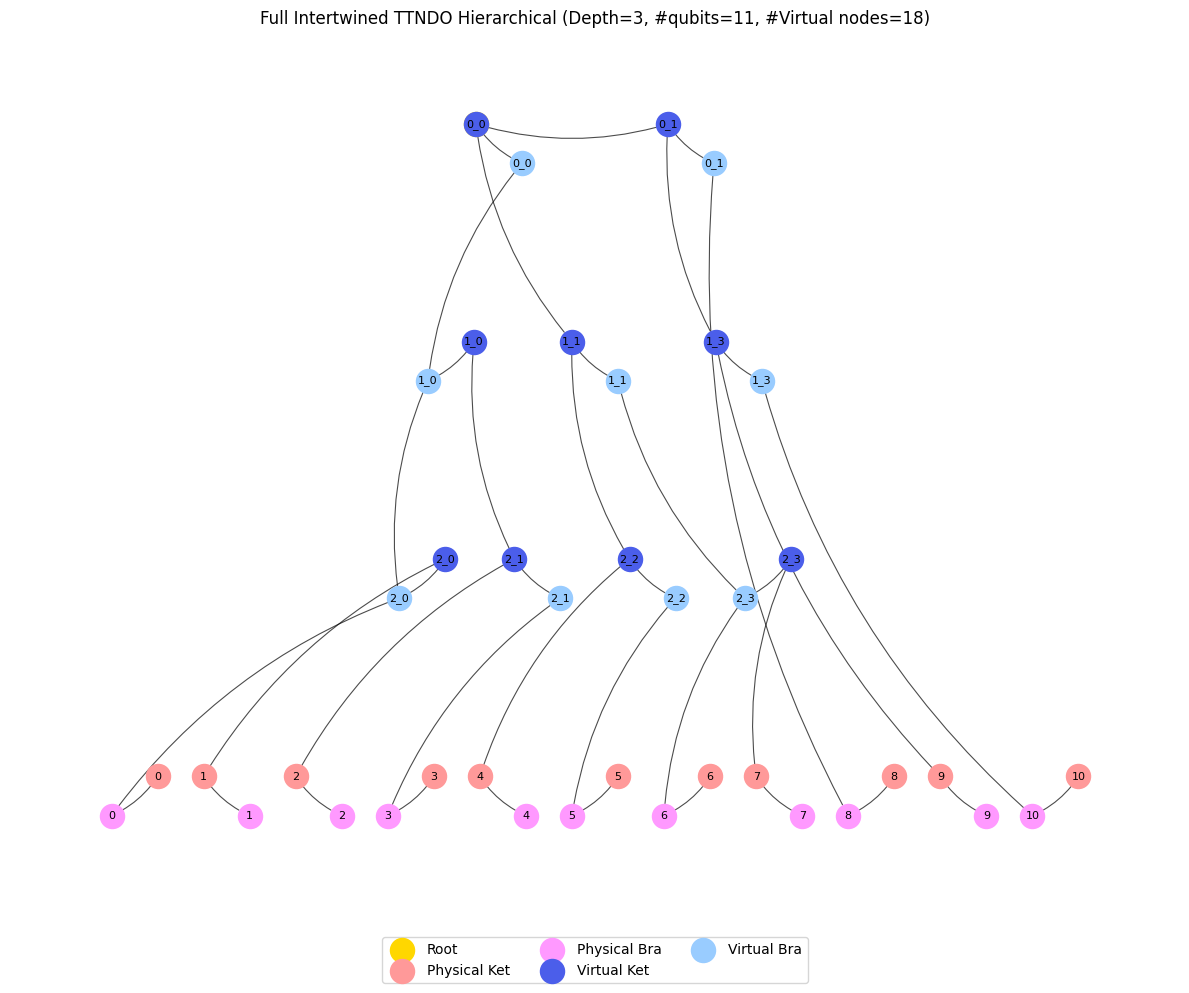

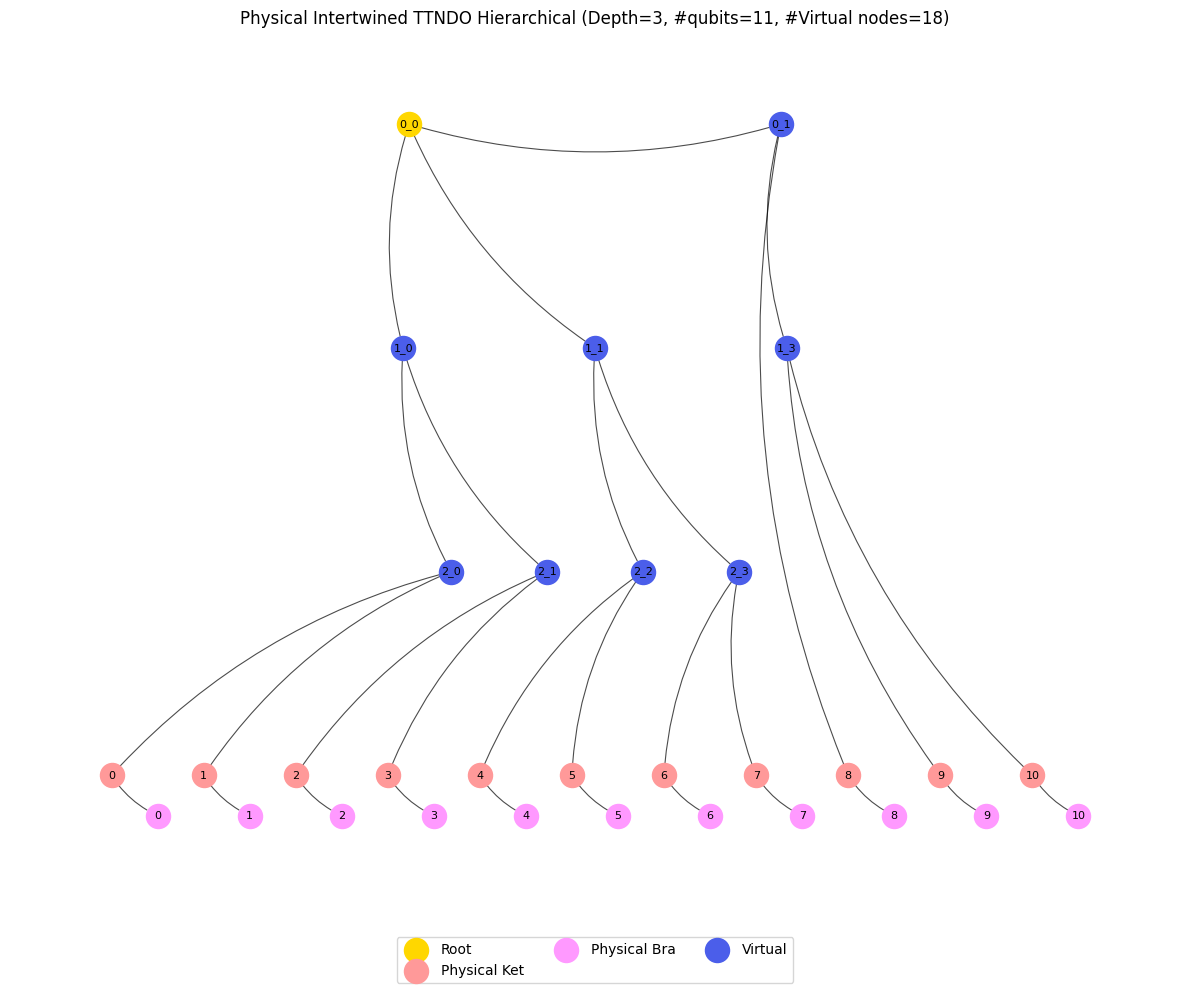

Visualizing networks: depth=2, sites=11
TTNS: 19 total nodes, 8 virtual nodes
Symmetric TTNDO: 39 total nodes, 17 virtual nodes
Intertwined TTNDO: 38 total nodes, 16 virtual nodes
Creating Binary TTNS Hierarchical plot...


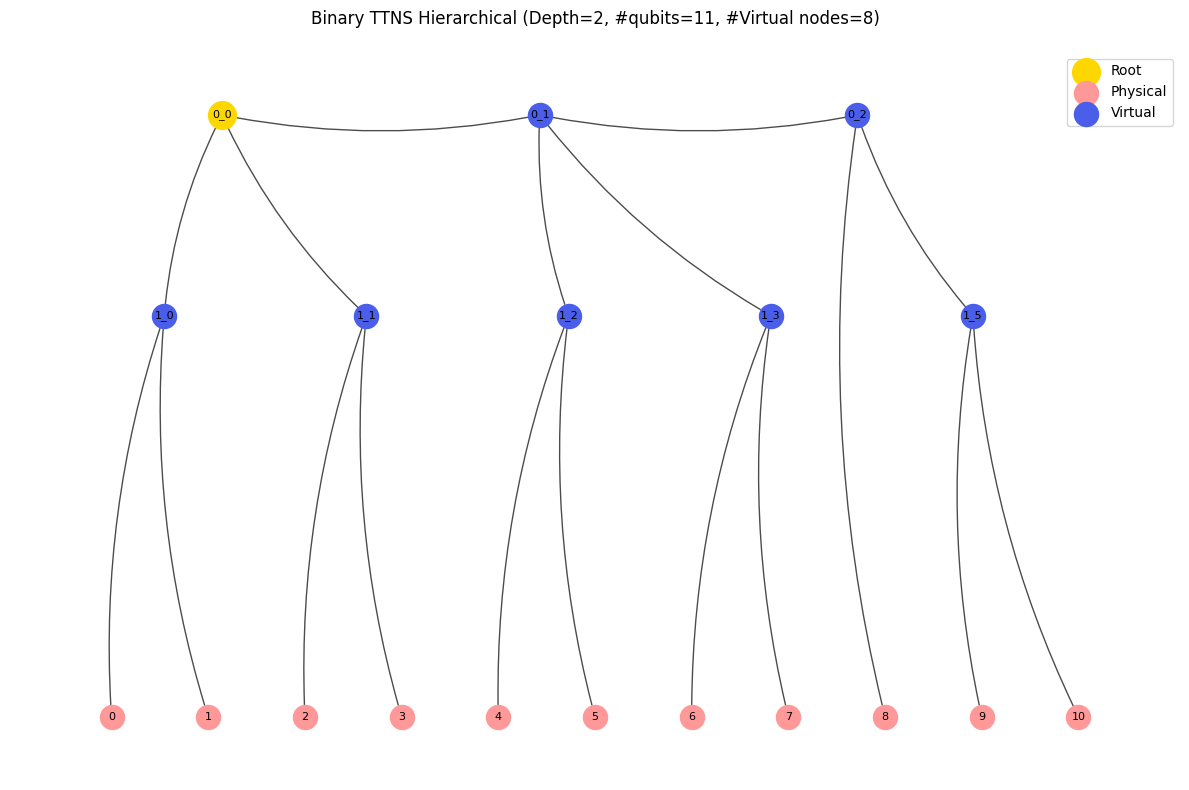

Creating Symmetric TTNDO plot...


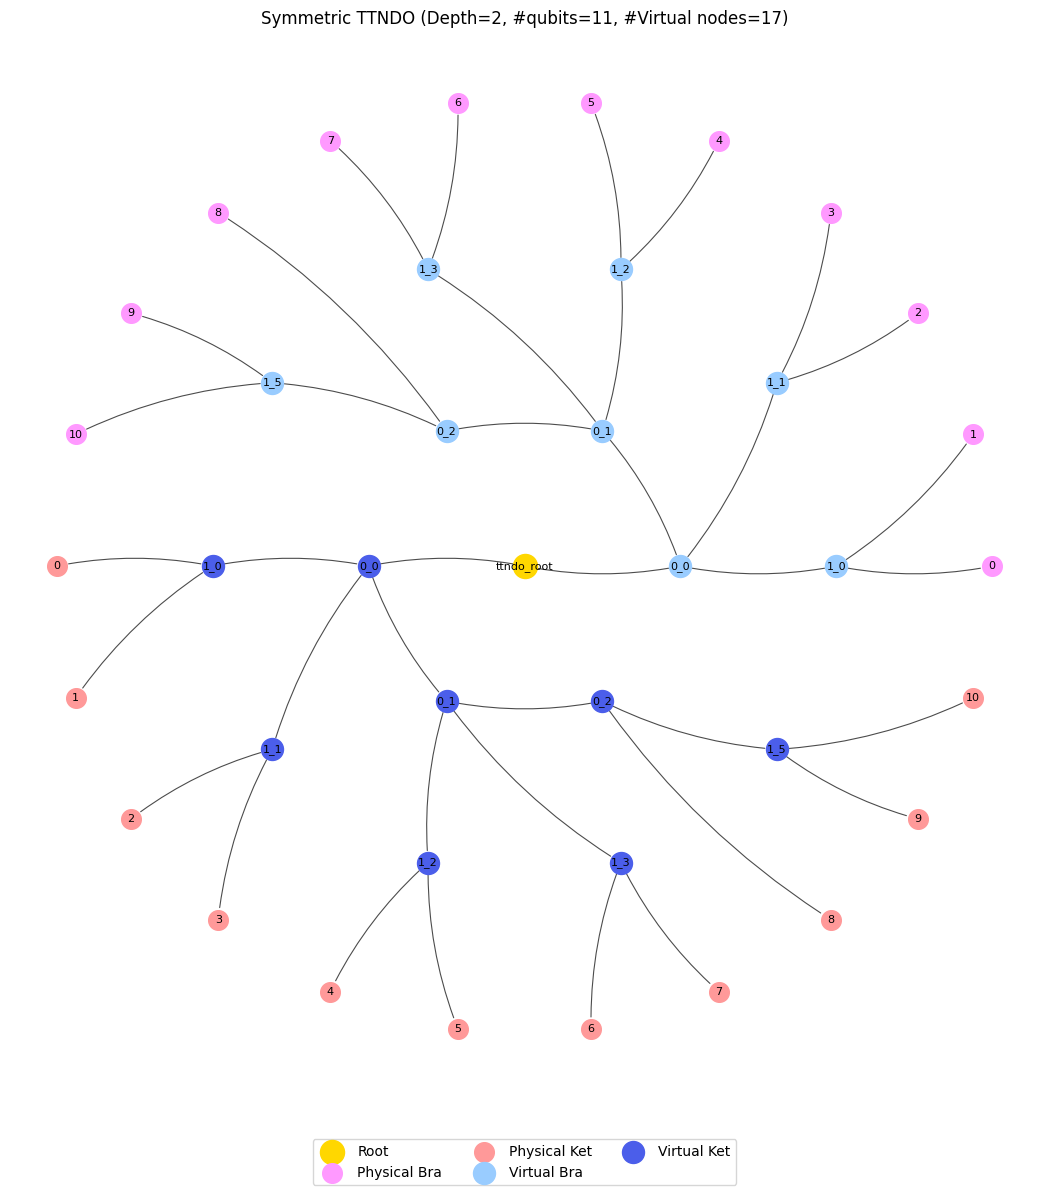

Creating Intertwined TTNDO Hierarchical plot...


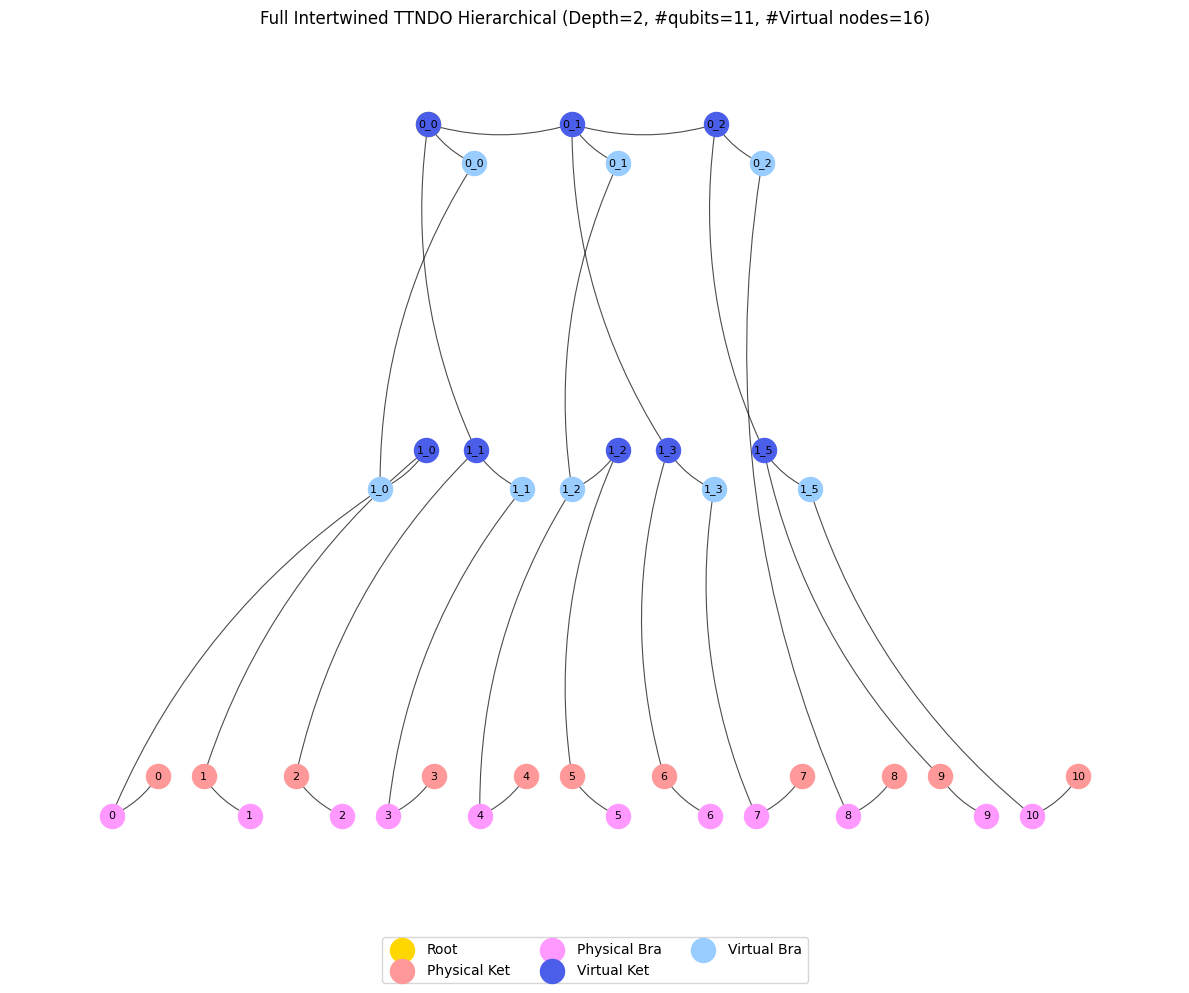

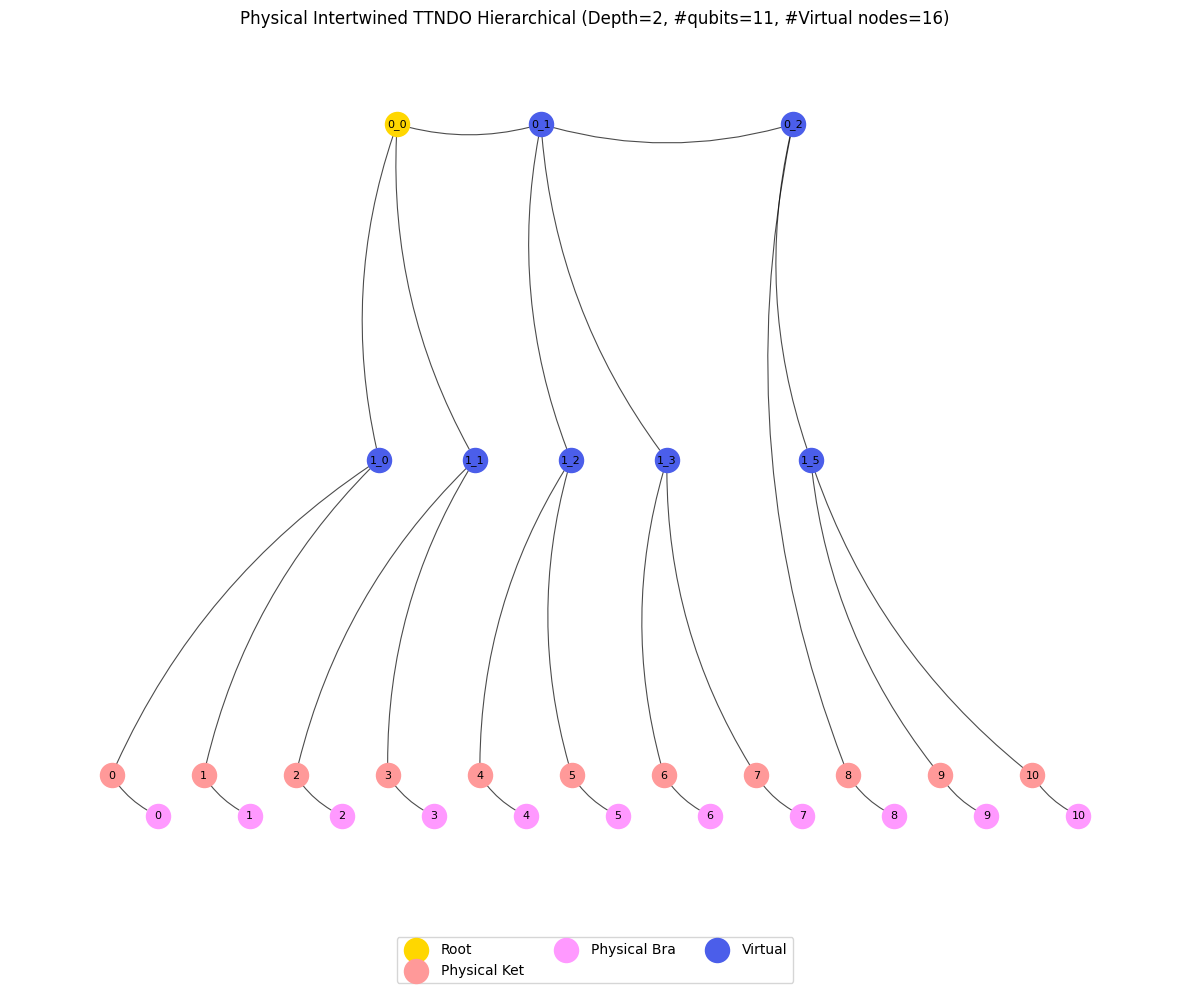

Visualizing networks: depth=1, sites=11
TTNS: 16 total nodes, 5 virtual nodes
Symmetric TTNDO: 33 total nodes, 11 virtual nodes
Intertwined TTNDO: 32 total nodes, 10 virtual nodes
Creating Binary TTNS Hierarchical plot...


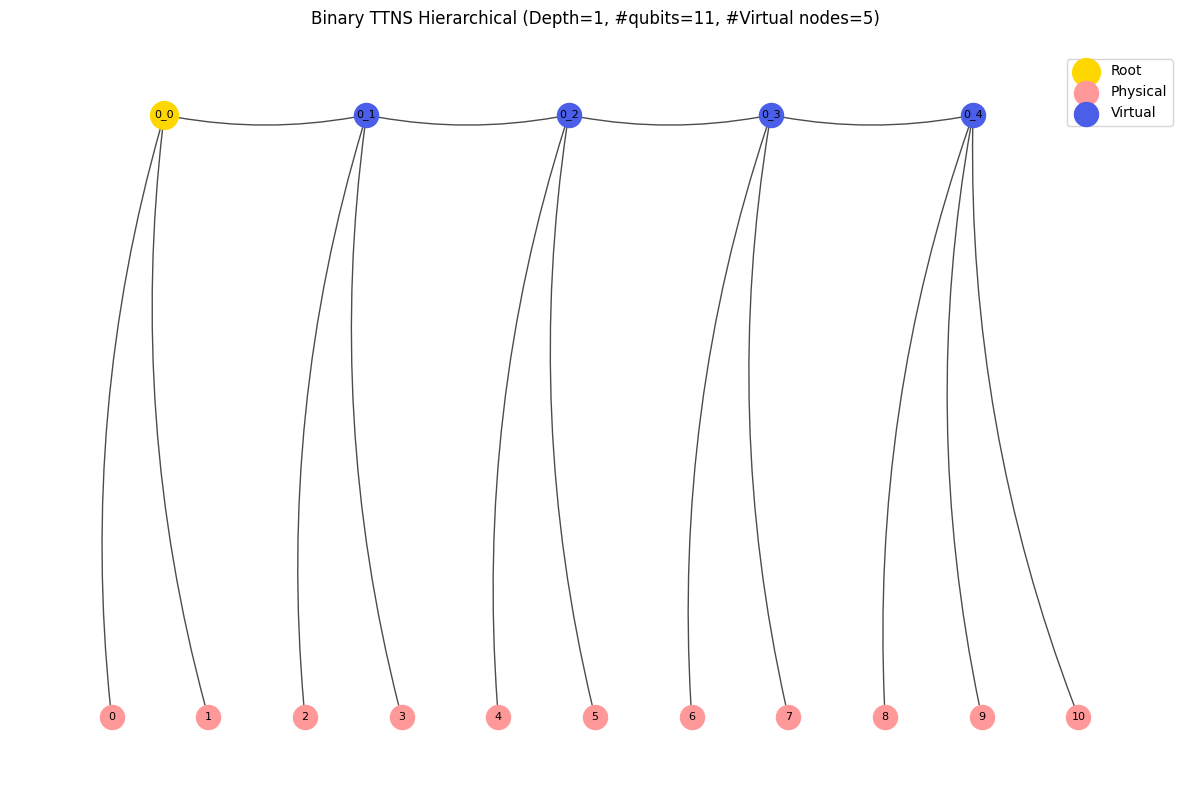

Creating Symmetric TTNDO plot...


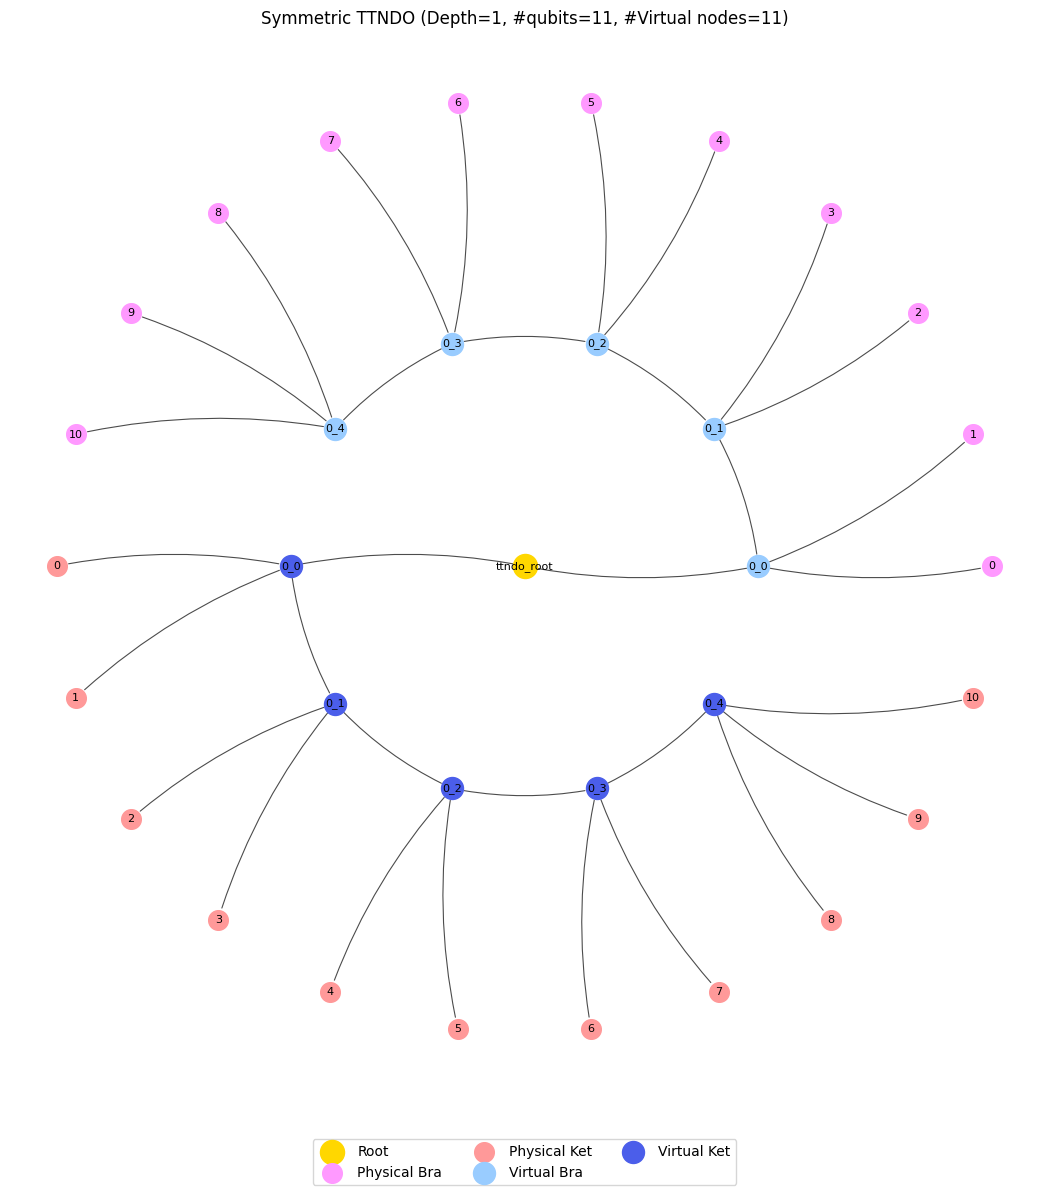

Creating Intertwined TTNDO Hierarchical plot...


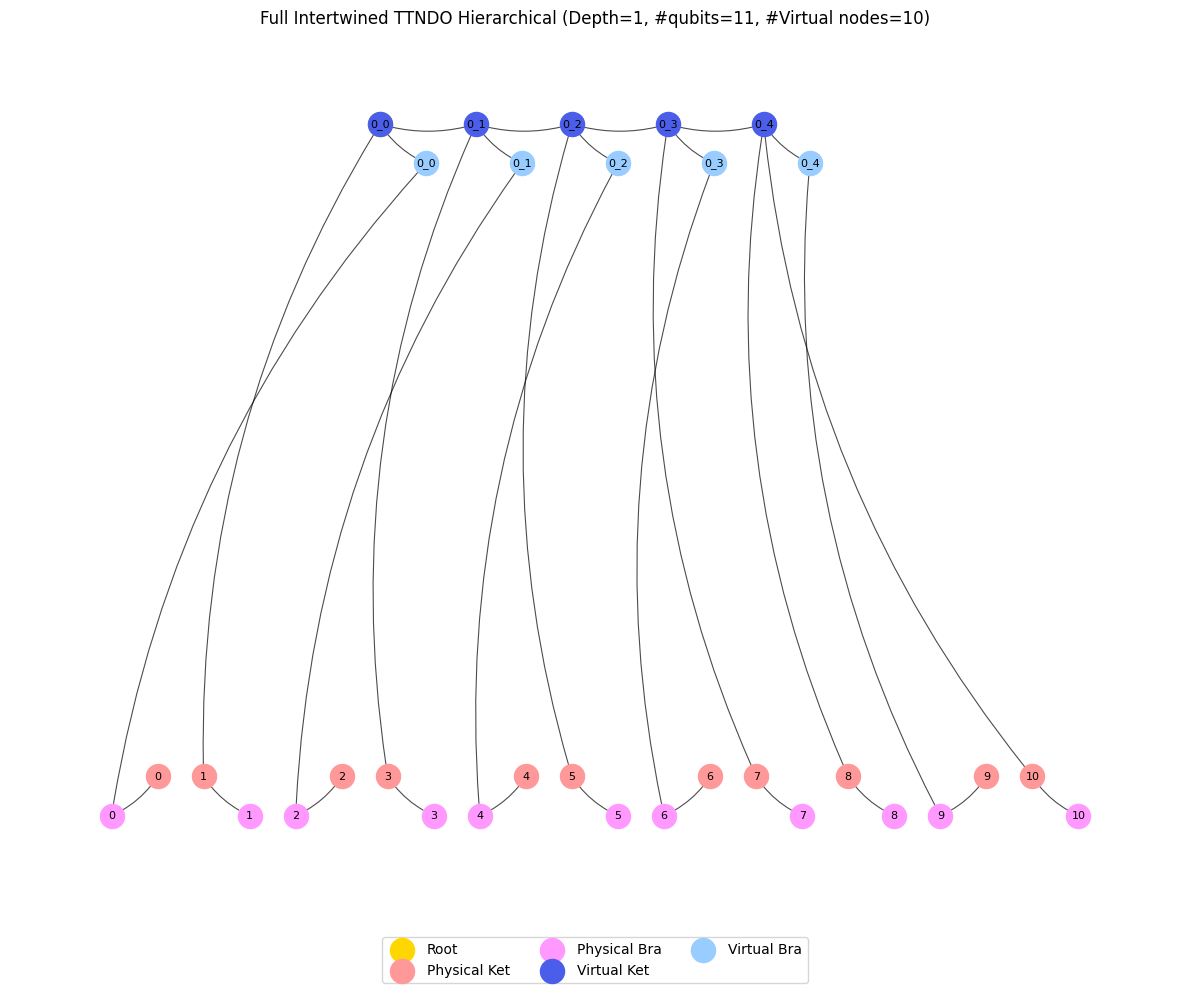

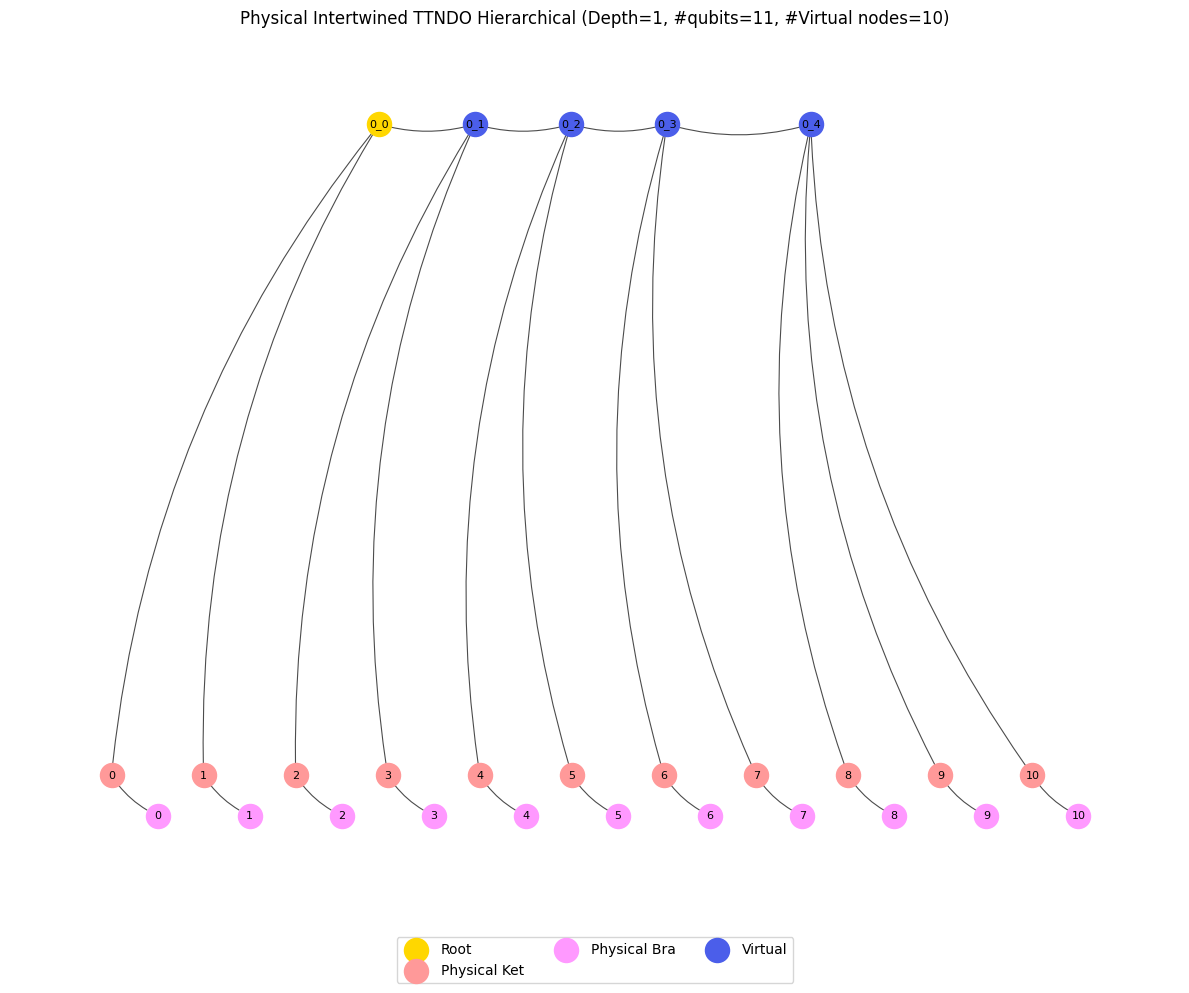

In [71]:
depths = [4,3,2,1]

for depth in depths:
    print(f"Visualizing networks: depth={depth}, sites={length}")
    
    # 1. Generate the binary TTNS
    ttns = generate_binary_ttns(num_phys=length,
                                bond_dim=initial_bond_dim,
                                phys_tensor=phys_tensor,
                                depth=depth)
    
    # Count virtual nodes in TTNS
    ttns_virtual_count = sum(1 for node_id in ttns.nodes 
                            if not ("qubit" in node_id or "site" in node_id))
    print(f"TTNS: {len(ttns.nodes)} total nodes, {ttns_virtual_count} virtual nodes")
    

    # 2. Generate the TTNDOs
    try:
        ttndo_symmetric = from_ttns_symmetric(ttns , initial_bond_dim)
        
        # SYMMETRIC TTNDO: Double TTNS virtual count + 1 for ttndo_root
        sym_virtual_count = ttns_virtual_count * 2 + 1
        print(f"Symmetric TTNDO: {len(ttndo_symmetric.nodes)} total nodes, {sym_virtual_count} virtual nodes")
    except Exception as e:
        print(f"Error creating symmetric TTNDO: {e}")
        ttndo_symmetric = None
        sym_virtual_count = 0
        
    try:
        ttndo_fully_intertwined = from_ttns_fully_intertwined(ttns, bond_dim=initial_bond_dim, phys_tensor=phys_tensor)
            
        # INTERTWINED TTNDO: Count ket virtual nodes and double it
        int_ket_virtual_count = sum(1 for node_id in ttndo_fully_intertwined.nodes 
                                    if "_ket" in node_id and not ("qubit" in node_id or "site" in node_id))
        int_virtual_count = int_ket_virtual_count * 2
        print(f"Intertwined TTNDO: {len(ttndo_fully_intertwined.nodes)} total nodes, {int_virtual_count} virtual nodes")
    except Exception as e:
        print(f"Error creating intertwined TTNDO: {e}")
        ttndo_fully_intertwined = None
        int_virtual_count = 0

    try:
        ttndo_physically_intertwined = from_ttns_physically_intertwined(ttns, bond_dim=initial_bond_dim, phys_tensor=phys_tensor)
    except Exception as e:
        print(f"Error creating intertwined TTNDO: {e}")    

    # Binary TTNS - Hierarchical
    print("Creating Binary TTNS Hierarchical plot...")
    visualize_binary_ttns(
        ttns, 
        title=f'Binary TTNS Hierarchical (Depth={depth}, #qubits={length}, #Virtual nodes={ttns_virtual_count})',
        layout_type="hierarchical",
        simplified_labels=True
    )
    
    # Symmetric TTNDO
    if ttndo_symmetric:
        print("Creating Symmetric TTNDO plot...")
        visualize_symmetric_ttndo(
            ttndo_symmetric, 
            title=f'Symmetric TTNDO (Depth={depth}, #qubits={length}, #Virtual nodes={sym_virtual_count})',
            simplified_labels=True
        )
    
    # Intertwined TTNDO - Hierarchical
    if ttndo_fully_intertwined:
        print("Creating Intertwined TTNDO Hierarchical plot...")
        visualize_intertwined_ttndo(
            ttndo_fully_intertwined, 
            title=f'Full Intertwined TTNDO Hierarchical (Depth={depth}, #qubits={length}, #Virtual nodes={int_virtual_count})',
            layout_type="hierarchical",
            simplified_labels=True
        )

        visualize_intertwined_ttndo(
            ttndo_physically_intertwined, 
            title=f'Physical Intertwined TTNDO Hierarchical (Depth={depth}, #qubits={length}, #Virtual nodes={int_virtual_count})',
            layout_type="hierarchical",
            simplified_labels=True)

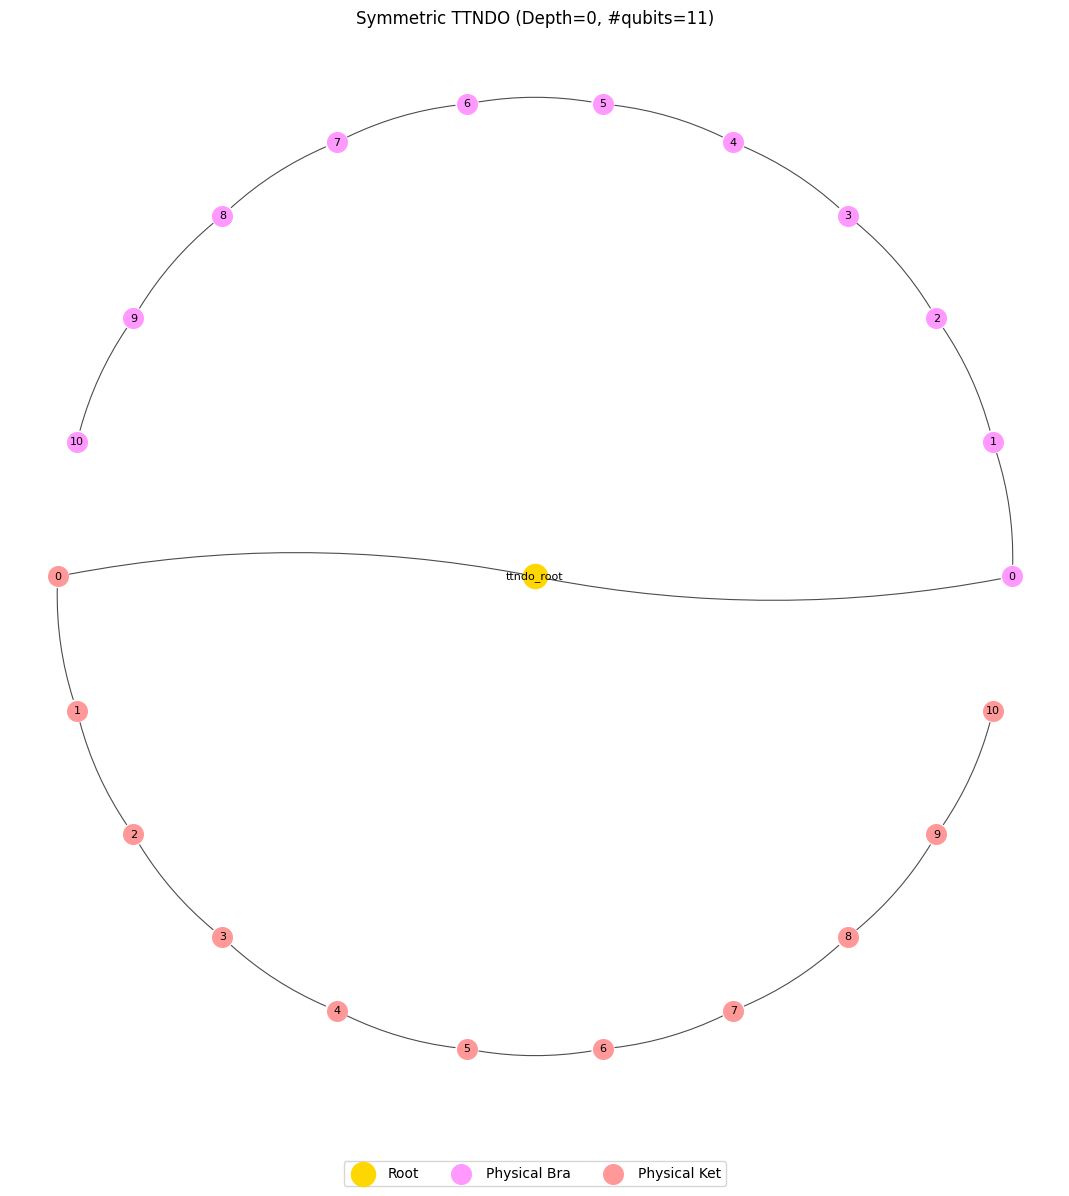

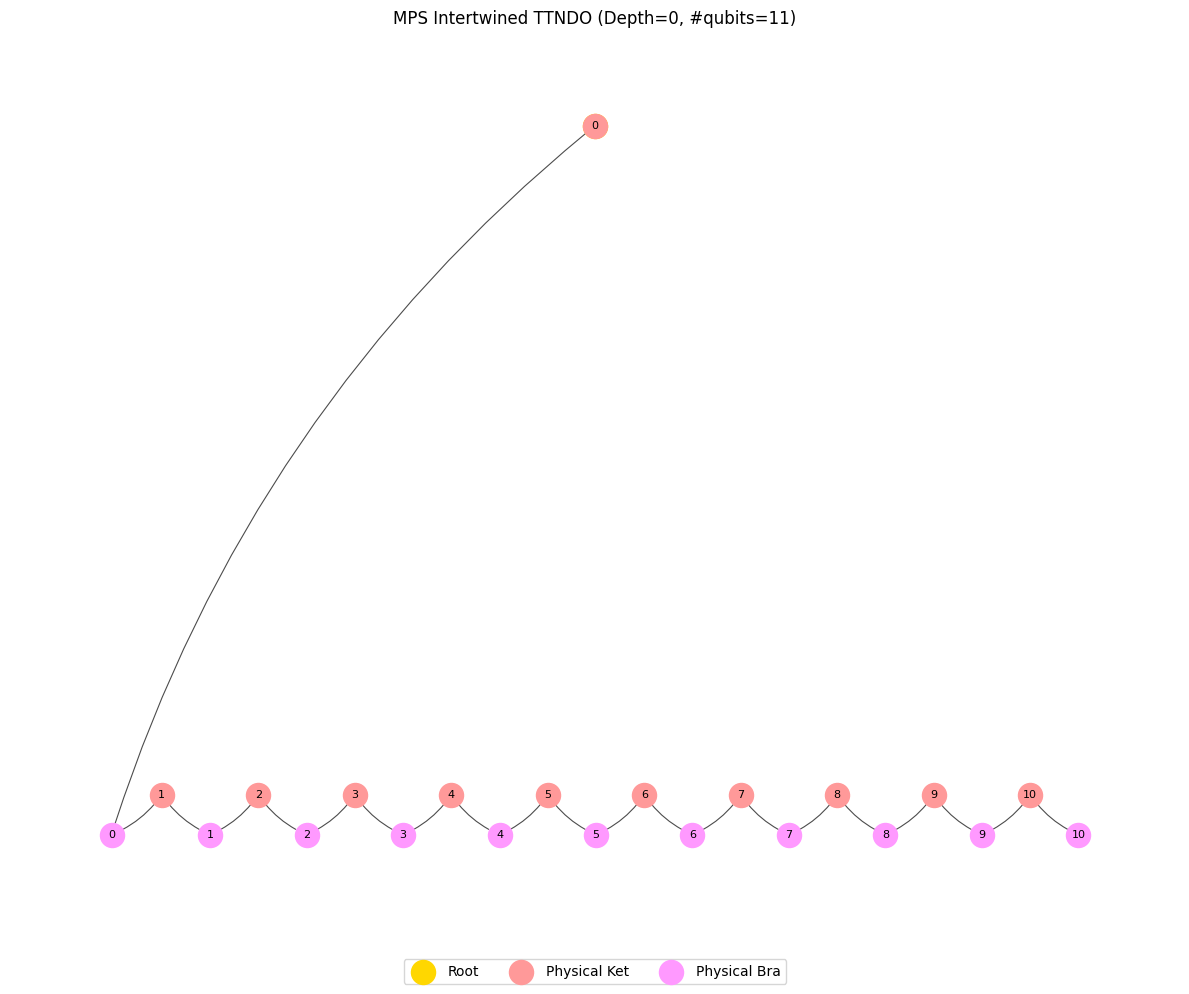

In [72]:
depth = 0 

ttns = generate_binary_ttns(num_phys=length,
                            bond_dim=initial_bond_dim,
                            phys_tensor=phys_tensor,
                            depth=depth)

ttndo_fully_intertwined = from_ttns_symmetric(ttns , initial_bond_dim)

visualize_symmetric_ttndo(
    ttndo_fully_intertwined, 
    title=f'Symmetric TTNDO (Depth={depth}, #qubits={length})',
    simplified_labels=True)


ttndo_mps_intertwined = from_mps_intertwined(ttns, bond_dim=initial_bond_dim, phys_tensor=phys_tensor)

visualize_intertwined_ttndo(
    ttndo_mps_intertwined, 
    title=f'MPS Intertwined TTNDO (Depth={depth}, #qubits={length})',
    layout_type="hierarchical",
    simplified_labels=True
)


## compare BUG with TJM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

from yaqs.general.data_structures.MPO import MPO
from yaqs.general.data_structures.MPS import MPS
from yaqs.general.data_structures.noise_model import NoiseModel
from yaqs.general.data_structures.simulation_parameters import Observable, PhysicsSimParams
from yaqs.physics.methods import TJM


# Define the system Hamiltonian
L = 11
d = 2
J = 1.0
g = 0.5
H_0 = MPO()
H_0.init_Ising(L, d, J, g)

# Define the initial state
state = MPS(L, state='zeros')

# Define the noise model
gamma = 0.1
noise_model = NoiseModel(['relaxation', 'dephasing'], [gamma, gamma])

# Define the simulation parameters
T = 0.4
dt = 0.01
sample_timesteps = True
N = 100
max_bond_dim = 6
threshold = 1e-6
order = 2
measurements = [Observable('z', site) for site in range(L)]
sim_params = PhysicsSimParams(measurements, T, dt, sample_timesteps, N, max_bond_dim, threshold, order)

# Run TJM
start_time = time.time()
TJM.run(state, H_0, sim_params, noise_model)
CPU_time = time.time() - start_time
print(f"CPU_time = {CPU_time:.2f} s")

# Calculate absolute error
TJM_results = []
for observable in sim_params.observables:
    TJM_results.append(observable.results)

TJM_results = np.array(TJM_results)
TJM_magns = np.sum(TJM_results, axis=0) / L    

tjm_error = np.abs(TJM_magns - exact_magns)
tjm_error = tjm_error.reshape(-1)


In [ ]:
depth = 1

initial_bond_dim = 8
max_effective_ham_dim = 3500
total_tol = 1e-12

bug_magns, bug_energy, trace, bond_dims = run_simulation(ttndo_type_name = "physically_intertwined", initial_bond_dim = initial_bond_dim, max_effective_ham_dim = max_effective_ham_dim, total_tol = total_tol, depth = depth, visualize= False)

# Calculate error
bug_error = np.abs(bug_magns - exact_magns)
bug_error = bug_error.reshape(-1)

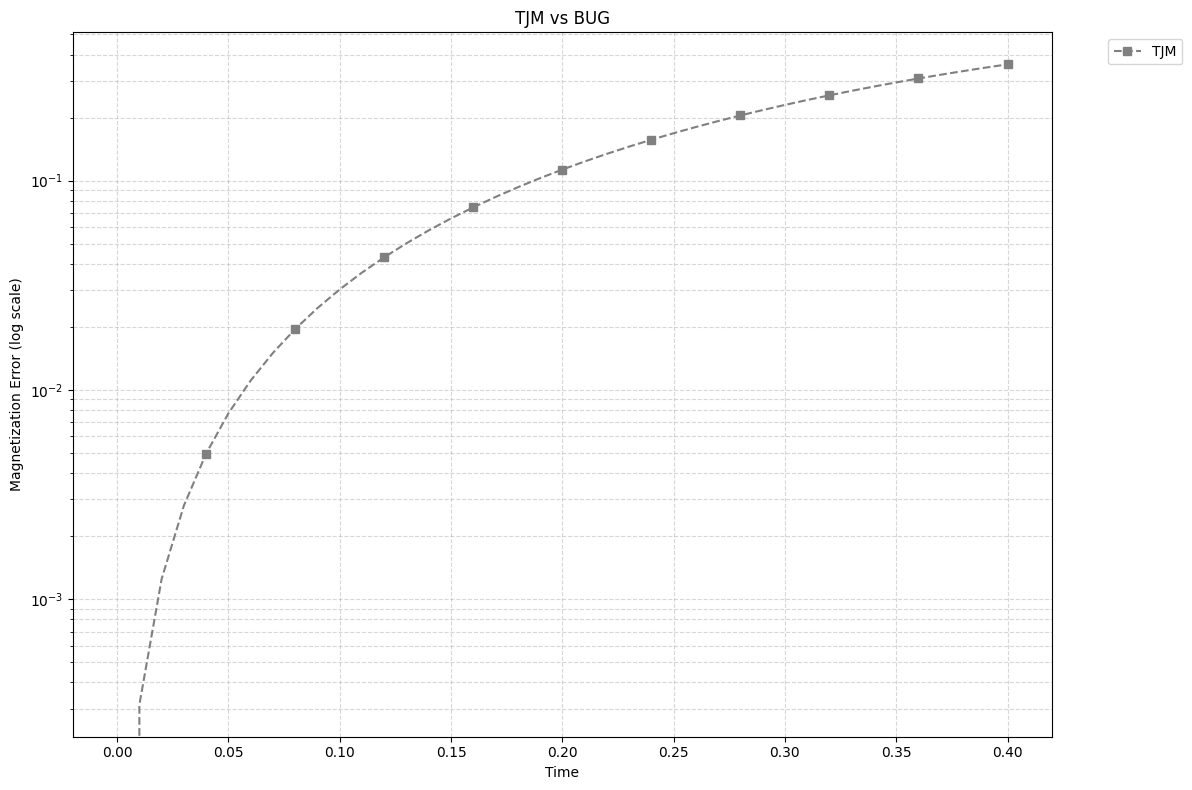

In [ ]:
plt.figure(figsize=(12, 8))
plt.semilogy(times,
            tjm_error,
            label='TJM',
            color='gray',
            linestyle='--',
            marker='s',
            markersize=6,
            markevery=max(1, len(times)//10))

plt.xlabel('Time')
plt.ylabel('Magnetization Error (log scale)')
plt.title('TJM vs BUG')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()